In [377]:
# Initial imports
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import datetime
import numpy as np
#import tensorflow as tf

#  Import and read the file.
supply_df = pd.read_csv("./CAISO-ALL-SUPPLY-DATA.csv")
supply_df.head()

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,7/5/21,11:50:00,7/5/21 11:50
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,8/18/20,16:25:00,8/18/20 16:25
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,8/18/20,15:55:00,8/18/20 15:55
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,8/18/20,15:50:00,8/18/20 15:50
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,8/18/20,15:40:00,8/18/20 15:40


In [378]:
supply_df['Sum'] = supply_df['Renewables'] + supply_df['Large hydro'] + supply_df['Imports'] + supply_df['Batteries'] + supply_df['Nuclear'] + supply_df['Coal'] + supply_df['Other'] + supply_df['Natural gas']



In [379]:
baby_df = supply_df['Time'].str.split(":", expand=True)
print(baby_df)

         0   1   2
0       11  50  00
1       16  25  00
2       15  55  00
3       15  50  00
4       15  40  00
...     ..  ..  ..
412947   2  35  00
412948   2  40  00
412949   2  45  00
412950   2  50  00
412951   2  55  00

[412952 rows x 3 columns]


In [380]:
baby_df[0] = baby_df[0].astype(int)
baby_df[1] = baby_df[1].astype(int)

In [381]:
baby_df= baby_df.drop([2],1)

In [382]:
# Rename columns and create years value for calculating demand_EV
baby_df = baby_df.rename(columns={baby_df.columns[0]: 'Hours'})
baby_df = baby_df.rename(columns={baby_df.columns[1]: 'Minutes'})

In [383]:
supply_df['Date'] = pd.to_datetime(supply_df['Date'])

#Create a new column for'Year'
baby_df['Year'] = supply_df['Date'].dt.year

#Convert to integers to be used in computations
baby_df['Year'] = baby_df['Year'].astype(int)



baby_df.head(100)

,Hours,Minutes,Year
0,11,50,2021
1,16,25,2020
2,15,55,2020
3,15,50,2020
4,15,40,2020
...,...,...,...
95,17,15,2020
96,17,15,2020
97,15,50,2020
98,15,50,2020


In [384]:
baby_df['DemandMW'] = 0.0

mask = (baby_df['Year'] == 2018) & (baby_df['Hours']<=6) | (baby_df['Hours']>=22)
mask1 = (baby_df['Year'] == 2019) & (baby_df['Hours']<=6) | (baby_df['Hours']>=22)
mask2 = (baby_df['Year'] == 2020) & (baby_df['Hours']<=6) | (baby_df['Hours']>=22)


baby_df.loc[mask,'DemandMW'] = 6.2356
baby_df.loc[mask1,'DemandMW'] = 8.2818
baby_df.loc[mask2,'DemandMW'] = 9.9174

In [385]:
#Create a date attribute for groupby function 
supply_df['Month-D.A'] = supply_df['Date'].dt.month

supply_df['Day-DA'] = supply_df['Date'].dt.day
supply_df['Month-D.A'] = supply_df['Month-D.A'].astype(str)
supply_df['Day-DA'] = supply_df['Day-DA'].astype(str)

supply_df['DateAttribute'] = supply_df['Month-D.A'] + supply_df['Day-DA']


supply_df

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Sum,Month-D.A,Day-DA,DateAttribute
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,2021-07-05,11:50:00,7/5/21 11:50,59874.0,7,5,75
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,2020-08-18,16:25:00,8/18/20 16:25,47279.0,8,18,818
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,2020-08-18,15:55:00,8/18/20 15:55,47243.0,8,18,818
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,2020-08-18,15:50:00,8/18/20 15:50,47210.0,8,18,818
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,2020-08-18,15:40:00,8/18/20 15:40,47209.0,8,18,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:35:00,3/14/22 2:35,NaN,3,14,314
412948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:40:00,3/14/22 2:40,NaN,3,14,314
412949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:45:00,3/14/22 2:45,NaN,3,14,314
412950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:50:00,3/14/22 2:50,NaN,3,14,314


In [386]:
supply_df['Date'] = pd.to_datetime(supply_df['Date'])

In [387]:
def fun(datetimething):
     return datetimething.timetuple().tm_yday

In [388]:
supply_df['Date'] = supply_df['Date'].apply(fun)
supply_df.head(1300)

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Sum,Month-D.A,Day-DA,DateAttribute
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,186,11:50:00,7/5/21 11:50,59874.0,7,5,75
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,231,16:25:00,8/18/20 16:25,47279.0,8,18,818
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,231,15:55:00,8/18/20 15:55,47243.0,8,18,818
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,231,15:50:00,8/18/20 15:50,47210.0,8,18,818
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,231,15:40:00,8/18/20 15:40,47209.0,8,18,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,13006.0,20240.0,3017.0,4564.0,-15.0,2257.0,20.0,0.0,232,12:55:00,8/19/20 12:55,43089.0,8,19,819
1296,13006.0,20240.0,3017.0,4564.0,-15.0,2257.0,20.0,0.0,233,12:55:00,8/20/20 12:55,43089.0,8,20,820
1297,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,232,19:15:00,8/19/20 19:15,43087.0,8,19,819
1298,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,233,19:15:00,8/20/20 19:15,43087.0,8,20,820


In [389]:
final_df = pd.merge(baby_df, supply_df, left_index=True, right_index=True, how='outer')

In [390]:
final_df.head()

,Hours,Minutes,Year,DemandMW,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Sum,Month-D.A,Day-DA,DateAttribute
0,11,50,2021,0.0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,186,11:50:00,7/5/21 11:50,59874.0,7,5,75
1,16,25,2020,0.0,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,231,16:25:00,8/18/20 16:25,47279.0,8,18,818
2,15,55,2020,0.0,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,231,15:55:00,8/18/20 15:55,47243.0,8,18,818
3,15,50,2020,0.0,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,231,15:50:00,8/18/20 15:50,47210.0,8,18,818
4,15,40,2020,0.0,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,231,15:40:00,8/18/20 15:40,47209.0,8,18,818


In [391]:
final_df= final_df.drop(['Renewables', 'Batteries', 'Large hydro', 'Imports', 'Other', 'Nuclear', 'Coal', 'DateTime'],1)
final_df.head(1000)

,Hours,Minutes,Year,DemandMW,Natural gas,Date,Time,Sum,Month-D.A,Day-DA,DateAttribute
0,11,50,2021,0.0,5568.0,186,11:50:00,59874.0,7,5,75
1,16,25,2020,0.0,26540.0,231,16:25:00,47279.0,8,18,818
2,15,55,2020,0.0,26159.0,231,15:55:00,47243.0,8,18,818
3,15,50,2020,0.0,26132.0,231,15:50:00,47210.0,8,18,818
4,15,40,2020,0.0,26015.0,231,15:40:00,47209.0,8,18,818
...,...,...,...,...,...,...,...,...,...,...,...
995,18,0,2019,0.0,19813.0,238,18:00:00,43499.0,8,26,826
996,18,0,2019,0.0,19813.0,239,18:00:00,43499.0,8,27,827
997,15,20,2020,0.0,23554.0,228,15:20:00,43499.0,8,15,815
998,17,40,2018,0.0,18174.0,208,17:40:00,43497.0,7,27,727


In [392]:
supply_df.dtypes

Renewables       float64
Natural gas      float64
Large hydro      float64
Imports          float64
Batteries        float64
Nuclear          float64
Coal             float64
Other            float64
Date               int64
Time              object
DateTime          object
Sum              float64
Month-D.A         object
Day-DA            object
DateAttribute     object
dtype: object

In [393]:
final_df= final_df.drop(['Time'],1)

In [394]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

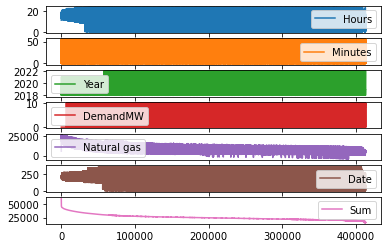

In [395]:
axes = final_df.plot.line(subplots=True)

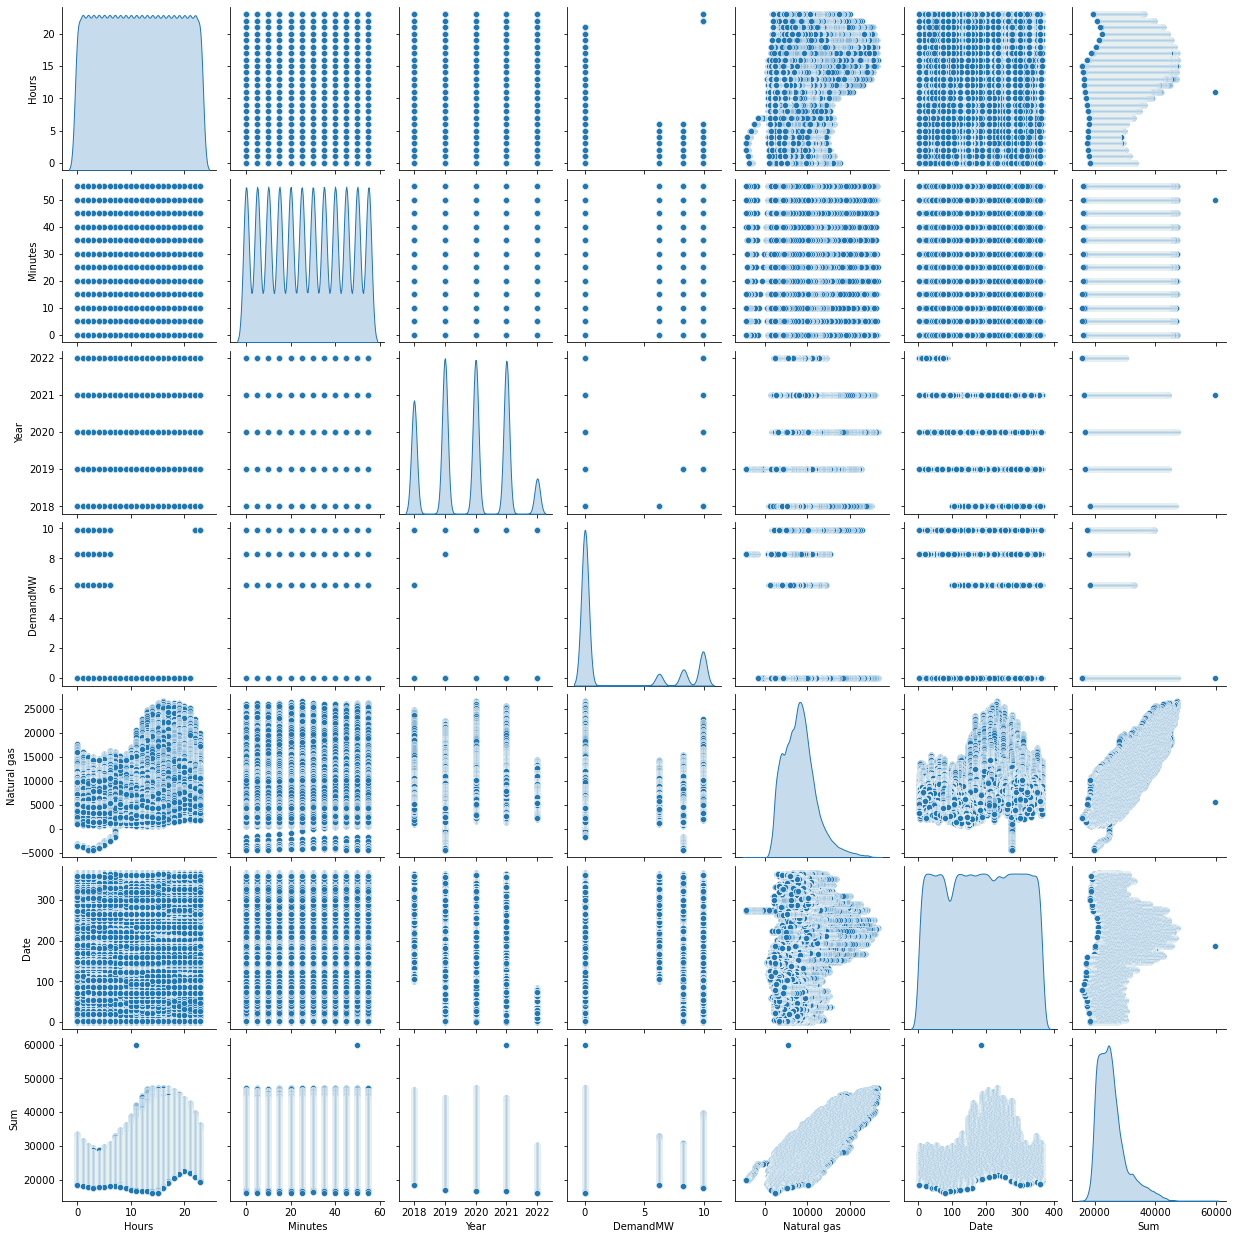

In [396]:
import seaborn as sns
sns.pairplot(data=final_df, diag_kind='kde')

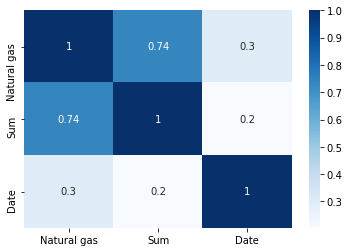

In [397]:
sns.heatmap(final_df[['Natural gas','Sum', 'Date']].corr(), cmap='Blues', annot=True)
plt.show()

In [398]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(final_df[['Natural gas','Sum']])
final_df[['Natural gas','Sum']] = imputer.transform(final_df[['Natural gas','Sum']])
final_df

,Hours,Minutes,Year,DemandMW,Natural gas,Date,Sum,Month-D.A,Day-DA,DateAttribute
0,11,50,2021,0.0,5568.0,186,59874.0,7,5,75
1,16,25,2020,0.0,26540.0,231,47279.0,8,18,818
2,15,55,2020,0.0,26159.0,231,47243.0,8,18,818
3,15,50,2020,0.0,26132.0,231,47210.0,8,18,818
4,15,40,2020,0.0,26015.0,231,47209.0,8,18,818
...,...,...,...,...,...,...,...,...,...,...
412947,2,35,2022,0.0,7891.0,73,24551.0,3,14,314
412948,2,40,2022,0.0,7891.0,73,24551.0,3,14,314
412949,2,45,2022,0.0,7891.0,73,24551.0,3,14,314
412950,2,50,2022,0.0,7891.0,73,24551.0,3,14,314


In [399]:
final_df= final_df.drop(['Year', 'DemandMW', 'Month-D.A', 'Day-DA', 'DateAttribute'],1)

In [400]:
# Create our features
X = final_df.drop("Natural gas", axis = 1)

# Create our target
y = final_df.loc[:, 'Natural gas'].copy()

In [401]:
final_df.isnull().values.any()

False

In [402]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [403]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [404]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)
print(model.predict(X_train))


[ 6959.86577591 14844.84124836  7950.12173923 ...  8554.45616826
  9093.89595198  9833.69617641]


In [405]:
print(training_score)

0.5690242668873742


In [406]:
print(testing_score)

0.5705012639915177


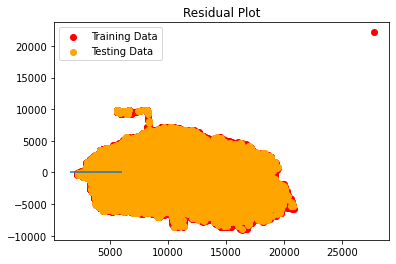

In [407]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="red", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=6000, xmax=1500)
plt.title("Residual Plot")
plt.show()

In [408]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all our features in X
model.fit(X, y)
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.5693226987782648


Predicting Future Natural Gas Demand

In [337]:
df2030 = pd.read_csv("./CAISO-ALL-SUPPLY-DATA.csv")
df2030.head()

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,7/5/21,11:50:00,7/5/21 11:50
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,8/18/20,16:25:00,8/18/20 16:25
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,8/18/20,15:55:00,8/18/20 15:55
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,8/18/20,15:50:00,8/18/20 15:50
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,8/18/20,15:40:00,8/18/20 15:40


In [338]:
df2030['Sum'] = df2030['Renewables'] + df2030['Large hydro'] + df2030['Imports'] + df2030['Batteries'] + df2030['Nuclear'] + df2030['Coal'] + df2030['Other'] + df2030['Natural gas']

In [339]:
other_df = df2030['Time'].str.split(":", expand=True)
print(other_df)

         0   1   2
0       11  50  00
1       16  25  00
2       15  55  00
3       15  50  00
4       15  40  00
...     ..  ..  ..
412947   2  35  00
412948   2  40  00
412949   2  45  00
412950   2  50  00
412951   2  55  00

[412952 rows x 3 columns]


In [340]:
#Format the baby_df into int.
other_df[0] = other_df[0].astype(int)
other_df[1] = other_df[1].astype(int)
#Clean baby_df
other_df= other_df.drop([2],1)

# Rename columns and create years value for calculating demand_EV
other_df = other_df.rename(columns={other_df.columns[0]: 'Hours'})
other_df = other_df.rename(columns={other_df.columns[1]: 'Minutes'})
other_df

,Hours,Minutes
0,11,50
1,16,25
2,15,55
3,15,50
4,15,40
...,...,...
412947,2,35
412948,2,40
412949,2,45
412950,2,50


In [341]:
df2030['Date'] = pd.to_datetime(df2030['Date'])

#Create a new column for'Year'
other_df['Year'] = df2030['Date'].dt.year
#Convert to integers to be used in computations
other_df['Year'] = other_df['Year'].astype(int)

other_df.head(100)

,Hours,Minutes,Year
0,11,50,2021
1,16,25,2020
2,15,55,2020
3,15,50,2020
4,15,40,2020
...,...,...,...
95,17,15,2020
96,17,15,2020
97,15,50,2020
98,15,50,2020


In [342]:
#Make a date string column 
date_df = pd.DataFrame()
df2030['Date1']=df2030['Date'].astype(str)

date_df = df2030['Date1'].str.split("-", expand=True)
date_df['DateAttribute'] = date_df[1] + date_df[2]
date_df = date_df.drop([0,1,2],1)

In [343]:
calc_df = pd.merge(other_df, date_df, left_index=True, right_index=True, how='outer')
calc_df.head(-5)

,Hours,Minutes,Year,DateAttribute
0,11,50,2021,0705
1,16,25,2020,0818
2,15,55,2020,0818
3,15,50,2020,0818
4,15,40,2020,0818
...,...,...,...,...
412942,2,10,2022,0314
412943,2,15,2022,0314
412944,2,20,2022,0314
412945,2,25,2022,0314


In [344]:
def fun(datetimething):
     return datetimething.timetuple().tm_yday

In [345]:
df2030['Date'] = df2030['Date'].apply(fun)
df2030.head(1300)

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Sum,Date1
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,186,11:50:00,7/5/21 11:50,59874.0,2021-07-05
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,231,16:25:00,8/18/20 16:25,47279.0,2020-08-18
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,231,15:55:00,8/18/20 15:55,47243.0,2020-08-18
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,231,15:50:00,8/18/20 15:50,47210.0,2020-08-18
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,231,15:40:00,8/18/20 15:40,47209.0,2020-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,13006.0,20240.0,3017.0,4564.0,-15.0,2257.0,20.0,0.0,232,12:55:00,8/19/20 12:55,43089.0,2020-08-19
1296,13006.0,20240.0,3017.0,4564.0,-15.0,2257.0,20.0,0.0,233,12:55:00,8/20/20 12:55,43089.0,2020-08-20
1297,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,232,19:15:00,8/19/20 19:15,43087.0,2020-08-19
1298,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,233,19:15:00,8/20/20 19:15,43087.0,2020-08-20


In [346]:
df2030 = df2030.drop(['Date1'],1)
df2030final = pd.merge(df2030, calc_df, left_index=True, right_index=True, how='outer')
df2030final
df2030final['DateTime'] = pd.to_datetime(df2030final['DateTime'])

In [347]:
df1= pd.DataFrame()
df1 = df2030final.groupby(['DateAttribute','Time'])['Sum'].agg('mean')
df1 = df1.reset_index()
df1 = df1.rename(columns={df1.columns[2]: 'AvgSUM(3yr)'}).round(2)
df2 = df1.copy

print(len(df1))
df1.dtypes

105408


DateAttribute     object
Time              object
AvgSUM(3yr)      float64
dtype: object

In [348]:
df1['Date1']= "2020" + df1['DateAttribute']
df1['pDateTime'] = df1['Date1'] +" " +df1['Time']
df1['Date2']= pd.to_datetime(df1['pDateTime'])
df1=df1.set_index('Date2')       
                                            
df1=df1.sort_index(ascending=True)
df1=df1.reset_index()
ev_df2=df1.drop(['DateAttribute','Date1','pDateTime','Time'],1)

In [349]:
df1 = df1.drop(df1.index[16992:17280])
df1 = df1.reset_index(drop=True)
print(len(df1))
df1

105120


,Date2,DateAttribute,Time,AvgSUM(3yr),Date1,pDateTime
0,2020-01-01 00:00:00,0101,0:00:00,23008.50,20200101,20200101 0:00:00
1,2020-01-01 00:05:00,0101,0:05:00,22992.00,20200101,20200101 0:05:00
2,2020-01-01 00:10:00,0101,0:10:00,22944.25,20200101,20200101 0:10:00
3,2020-01-01 00:15:00,0101,0:15:00,22891.00,20200101,20200101 0:15:00
4,2020-01-01 00:20:00,0101,0:20:00,22834.25,20200101,20200101 0:20:00
...,...,...,...,...,...,...
105115,2020-12-31 23:35:00,1231,23:35:00,23266.50,20201231,20201231 23:35:00
105116,2020-12-31 23:40:00,1231,23:40:00,23171.50,20201231,20201231 23:40:00
105117,2020-12-31 23:45:00,1231,23:45:00,23105.00,20201231,20201231 23:45:00
105118,2020-12-31 23:50:00,1231,23:50:00,23031.75,20201231,20201231 23:50:00


In [350]:
df1= df1.drop(['DateAttribute', 'Date1', 'pDateTime'],1)
df1.head(1000)

,Date2,Time,AvgSUM(3yr)
0,2020-01-01 00:00:00,0:00:00,23008.50
1,2020-01-01 00:05:00,0:05:00,22992.00
2,2020-01-01 00:10:00,0:10:00,22944.25
3,2020-01-01 00:15:00,0:15:00,22891.00
4,2020-01-01 00:20:00,0:20:00,22834.25
...,...,...,...
995,2020-01-04 10:55:00,10:55:00,22957.50
996,2020-01-04 11:00:00,11:00:00,22929.25
997,2020-01-04 11:05:00,11:05:00,22828.50
998,2020-01-04 11:10:00,11:10:00,22846.00


In [351]:
time_df = df1['Time'].str.split(":", expand=True)
time_df.head()

,0,1,2
0,0,00,00
1,0,05,00
2,0,10,00
3,0,15,00
4,0,20,00


In [352]:
#Format the baby_df into int.
time_df[0] = time_df[0].astype(int)
time_df[1] = time_df[1].astype(int)


# Rename columns and create years value for calculating demand_EV
time_df = time_df.rename(columns={time_df.columns[0]: 'Hours'})
time_df = time_df.rename(columns={time_df.columns[1]: 'Minutes'})


In [353]:
final_demand_df = pd.merge(time_df, df1, left_index=True, right_index=True, how='outer')
final_demand_df.head()

,Hours,Minutes,2,Date2,Time,AvgSUM(3yr)
0,0,0,00,2020-01-01 00:00:00,0:00:00,23008.50
1,0,5,00,2020-01-01 00:05:00,0:05:00,22992.00
2,0,10,00,2020-01-01 00:10:00,0:10:00,22944.25
3,0,15,00,2020-01-01 00:15:00,0:15:00,22891.00
4,0,20,00,2020-01-01 00:20:00,0:20:00,22834.25


In [354]:
def fun(datetimething):
     return datetimething.timetuple().tm_yday

In [355]:
final_demand_df['Date2'] = final_demand_df['Date2'].apply(fun)

In [356]:
final_demand_df= final_demand_df.drop(['Time', 'Date2'],1)
df1.head(1000)

,Date2,Time,AvgSUM(3yr)
0,2020-01-01 00:00:00,0:00:00,23008.50
1,2020-01-01 00:05:00,0:05:00,22992.00
2,2020-01-01 00:10:00,0:10:00,22944.25
3,2020-01-01 00:15:00,0:15:00,22891.00
4,2020-01-01 00:20:00,0:20:00,22834.25
...,...,...,...
995,2020-01-04 10:55:00,10:55:00,22957.50
996,2020-01-04 11:00:00,11:00:00,22929.25
997,2020-01-04 11:05:00,11:05:00,22828.50
998,2020-01-04 11:10:00,11:10:00,22846.00


In [357]:
final_demand_df.head(1000)

,Hours,Minutes,2,AvgSUM(3yr)
0,0,0,00,23008.50
1,0,5,00,22992.00
2,0,10,00,22944.25
3,0,15,00,22891.00
4,0,20,00,22834.25
...,...,...,...,...
995,10,55,00,22957.50
996,11,0,00,22929.25
997,11,5,00,22828.50
998,11,10,00,22846.00


In [358]:
final_demand_df = final_demand_df.rename(columns={2: 'Day', 'AvgSUM(3yr)': 'AvgSum'})

In [359]:
final_demand_df.head()

,Hours,Minutes,Day,AvgSum
0,0,0,00,23008.50
1,0,5,00,22992.00
2,0,10,00,22944.25
3,0,15,00,22891.00
4,0,20,00,22834.25


In [360]:
len(final_demand_df)

105120

In [361]:
mask = (final_demand_df['Hours'] < 7) | (final_demand_df['Hours'] > 21)
final_demand_df.loc[mask, 'AvgSum'] += 106.68

In [362]:
final_demand_df.head(1000)

,Hours,Minutes,Day,AvgSum
0,0,0,00,23115.18
1,0,5,00,23098.68
2,0,10,00,23050.93
3,0,15,00,22997.68
4,0,20,00,22940.93
...,...,...,...,...
995,10,55,00,22957.50
996,11,0,00,22929.25
997,11,5,00,22828.50
998,11,10,00,22846.00


In [370]:
print(len(final_demand_df.loc[final_demand_df['AvgSum'] < 0]))
print(final_demand_df['AvgSum'].mean())
print(final_df['Sum'].mean())


0
25488.596306593685
25472.23918276216


In [409]:
x_scaled = scaler.transform(final_demand_df)
print (max(x_scaled[0]))
print (max(X_train_scaled[0]))

for natgas in model.predict(final_demand_df):
    print(natgas)

-0.49457326821784664
-0.12415408570437213
5828.295730575746
5818.418343041723
5790.721220101495
5759.887823729774
5727.058616992559
5683.53756901162
5620.771206791978
5583.522705674024
5546.844436089068
5507.315008839119
5451.106309248962
5408.44060856752
5369.710528890186
5323.908554777254
5279.8172752633145
5237.151574581874
5198.192378864924
5151.249941685994
5115.284461517285
5092.291748724296
5063.31160483482
5028.486587732108
4982.256939969426
4960.832363892183
4927.091810128586
4912.937686097073
4897.215425349816
4894.6084898615245
4855.221620494825
4818.25823514337
4790.133438553392
4766.427936344155
4749.707770414148
4736.836667331883
4715.697207021138
4680.444516268679
4643.282573307091
4671.8958142504725
4680.693509422152
4670.38844823838
4658.087576689113
4644.931357840349
4633.628391473829
4611.918699630087
4587.64296588785
4572.776052440089
4581.858863378267
4571.553802194496
4564.614130481834
4577.546004267753
4600.884603530898
4594.143489428367
4582.697965178599
4592.92

6066.006259732121
6076.514649502798
6139.199224542845
6135.451825988555
6161.784140799942
6212.0661799972695
6248.377546636131
6293.95517568622
6350.509761746533
6413.622010436327
6481.1535535068615
6564.310464007975
6598.91113604784
6597.587221508797
6671.818985092064
6748.474232690576
6825.842269705336
6904.208211902842
6999.966215856806
7111.263029084981
7219.708684648163
7354.67010649578
7518.000547110076
7670.012915220766
7789.43552779417
7915.7009187635595
8042.251425499446
8182.630046910548
8276.819914148766
8353.047488097529
8425.283441315301
8437.359967801724
8486.501543933055
8480.330661363521
8484.423946387964
8482.33124270579
8486.281969846981
8465.142509536237
8468.52300514443
8466.201185422638
8458.31960825411
8466.261956126295
8436.14134917082
8411.152826012336
8376.755482559374
8365.309958309605
8336.187256536881
8320.12388029624
8285.29886319353
8258.1719717863
8226.483228115081
8221.452808611546
8188.481043991082
8161.7818262336
8156.608848846816
8130.764978388832
808

7609.027773785761
7574.060198799802
7551.210043890062
7515.957353137601
7478.423736253148
7447.447781998177
7404.4969655502355
7354.988486472812
7328.859500248329
7280.206368470403
7231.410678809227
7185.980378619161
7116.513795886785
7076.1290213373395
7045.438182848868
6979.820662964234
6941.289140897032
6884.510209773876
6836.854983178697
6753.845401537606
6745.108477069582
6667.658652875227
6585.646976416883
6574.1055362329225
6468.856924804886
6408.65660448374
6352.590462776832
6256.1804401102745
6211.091255413588
6137.490494066975
6053.768123009637
5975.8906251655335
5914.977515428136
5833.393512619543
5775.33156054714
5699.678989108148
5618.094986299553
5542.0707409376955
5490.851567261276
5421.670100295401
5360.756990558006
5298.5608598713625
5256.60794860617
5172.172788132582
5120.383382923164
5088.694639251946
5026.926182215051
5064.755707890648
5059.012498970866
5051.558595452087
5004.188484623408
4966.512309855703
4935.964029250483
4886.883223822808
4857.190290517085
4837.3

4780.091123769656
4725.878234544993
4670.524882254334
4653.519600557829
4609.28576316064
4589.999555332142
4564.013126990909
4564.25734916761
4531.428142430395
4499.596840875927
4458.356719026982
4435.221448350741
4405.757631084636
4398.303727565857
4388.996571564832
4383.395920528299
4343.5813775118495
4312.74798114013
4318.979634413316
4294.13366913808
4275.845366492329
4248.718475085099
4254.522454708536
4254.19644535224
4246.829099989829
4255.05656362851
4249.455912591977
4246.848977103686
4229.130905990933
4237.358369629614
4209.376130922887
4222.450562592056
4218.560606154519
4228.783880158695
4237.439017447126
4238.538586923327
4250.1314400331175
4299.700689814195
4319.903015645848
4359.065539949703
4389.38947549208
4404.032043876996
4420.812980510656
4437.166243494568
4427.431413843795
4449.059318507943
4465.982813024853
4514.554157623186
4562.071597311888
4661.108432580593
4709.822335062174
4757.823448127507
4814.520592071067
4857.389621339413
4912.803744333727
4967.6476357950

6419.142379805235
6438.433358610506
6431.264570858226
6421.957414857203
6350.209905992833
6302.839795164155
6321.33142639681
6295.487555938827
6260.805096719367
6232.11006859639
6195.0041253616855
6171.726296802195
6136.901279699485
6106.154441484132
6066.054782701183
6084.974087583589
6053.998133328618
6035.852388566116
5979.21601532621
5963.493754578951
6003.0839525325555
6026.4225517957
5991.1698610432395
5969.745284965995
5995.079694594635
5965.330761562029
5927.7971446775755
5925.902998605532
5924.579084066489
5921.4019170451975
5917.939634257409
5893.8064583984215
5871.38397713843
5875.477262162873
5860.182675065364
5866.12921257205
5869.509708180245
5872.549088295058
5911.283938949164
5885.29751060793
5886.967311617129
5898.758722337052
5884.31948253904
5902.240882238699
5915.457871791117
5916.414883384068
5929.774430819736
5945.55746227065
5971.747219198787
5979.4910094608385
5932.976245931655
5974.847370017254
5954.420699122758
5983.461613715888
6009.6513706440255
6073.3338508

7280.707213179843
7442.897190728143
7588.9781274692305
7737.910221875312
7860.32654999696
7966.348721544897
8024.471444320956
8088.866713959997
8118.905533735875
8144.041385754383
8127.178661941127
8129.133578716825
8121.964790964545
8142.879906212445
8099.786531881255
8077.078934854764
8065.775968488244
8034.514898466774
8027.916342247494
7996.370156459525
7984.639516443256
7934.9324797557
7881.004706297537
7879.395675991993
7854.122037067009
7829.276071791774
7817.687989658754
7790.703656134774
7780.968826484001
7733.313599888823
7720.442496806558
7692.745373866328
7644.6624736214
7622.896782050775
7580.658755019082
7541.842117185382
7499.31897438719
7462.925820568733
7430.2391717147675
7377.5944192058505
7350.467527798621
7287.986281345478
7236.33943401931
7190.680017789626
7178.66426200686
7134.37442488279
7092.706629384094
7036.925603443688
6997.681291960236
6943.896076385323
6891.108765993158
6831.05100355526
6787.52995557432
6733.174508466409
6663.280252084285
6590.24972227067
6

4717.43504196337
4734.073420713781
4767.6761875709
4797.429891580277
4839.728689315625
4902.784938278537
5044.161464872388
5153.747583501567
5216.574716424864
5281.967891246653
5326.832730880493
5381.961738108308
5475.5813738135275
5546.249190315555
5609.7891126550985
5679.316466091128
5758.537755588133
5857.233475363457
6044.371082480442
6142.6951283329
6254.277057327574
6353.59900836278
6433.105413626285
6487.949305087599
6612.646559341241
6697.142490518483
6768.09542278701
6808.255852273611
6859.250680887188
6833.67584267613
6929.861520279843
7009.653041309846
7057.083922842181
7090.971805465799
7108.608089398958
7116.69299515439
7163.8387609202255
7172.3513403254055
7198.255981487044
7162.147943435086
7161.67937619554
7157.875977914369
7209.441038060944
7267.136087187253
7200.235546353371
7247.5238700024565
7229.948356772953
7206.242854563714
7214.897991852145
7218.421045343588
7217.667362337543
7182.557229468333
7129.912476959416
7089.471702683088
7050.369949082888
7081.5492319247

6632.2404142823
6621.650237332029
6602.649145270028
6602.465693796981
6596.722484877198
6593.489318129026
6607.846770747443
6615.504002853126
6625.442161090803
6589.904354571845
6626.500836977206
6552.900075630592
6564.976602117014
6580.759633567928
6573.1631721659
6532.778397616452
6487.546655036516
6431.567071485977
6430.385714830181
6390.000940280735
6338.781766604316
6287.990266577644
6277.257531744122
6224.897895001706
6161.988974898815
6134.576967725086
6077.370362952181
6035.702567453487
5996.4582559700375
5954.3067870947125
5869.871626621125
5807.247822284733
5799.508802999455
5762.260301881501
5739.837820621509
5738.799021848965
5678.028469994819
5683.975007501505
5650.718127114542
5606.911963367103
5575.365777579134
5538.488950384046
5494.967902403107
5426.214109086981
5405.217206659485
5410.736070516425
5373.772685164968
5352.490666970974
5331.636322426728
5325.1803240906975
5338.254755759866
5320.536684647113
5367.39733464645
5337.648401613844
5323.77939334883
5327.01733107

7445.716070923241
7391.360623815328
7359.18820676748
7303.977412360069
7261.026595912128
7198.117675809237
7149.179428264812
7089.977013126412
7030.204366455013
7002.222127748286
6916.5039463254525
6875.263824476508
6795.533074150158
6710.100008493824
6679.17069618791
6576.630684541618
6532.9670786774295
6473.19443200603
6389.044387298944
6314.018047119833
6239.56193847372
6171.378376690593
6100.0585414759735
6028.881264144604
5955.708176447737
5881.109509918377
5810.589022276372
5736.275471513509
5693.752328715318
5635.405260876416
5568.789835809033
5505.738357822895
5444.825248085497
5381.2035385663585
5307.175103569996
5253.675003761582
5191.906546724687
5108.184175667349
5184.504329820351
5204.991771418503
5194.4015944682305
5149.882641304544
5110.495771937845
5069.39820797215
5014.900202980989
4993.190511137245
4953.375968120796
4910.140035906357
4879.164081651386
4842.48581206643
4809.6006056023325
4772.779778134127
4744.2273078944
4714.534374588677
4671.726116023985
4651.7271187

6165.103865704483
6173.759002992912
6200.51899145405
6234.6919898441665
6219.539960629907
6283.3649987359495
6330.368206618536
6392.197434359083
6476.352250042944
6503.11223850408
6575.775865371601
6601.965622299738
6669.497165370272
6726.479425080333
6781.180758658398
6821.341188145001
6900.847593408505
6978.500746189764
7056.581572620773
7153.907713290482
7265.005968908525
7318.424281537345
7347.180080363976
7415.2818549675085
7547.534677033382
7662.965668875797
7750.027641951532
7854.196561017225
7984.453572717603
8114.7105844179805
8252.23804816409
8366.956250590258
8468.218012264075
8486.42452773023
8462.861583404243
8480.92554098715
8472.758848052123
8487.11630067054
8469.255671674537
8461.23153662276
8445.36671799225
8431.07003607749
8427.037521756702
8379.382295161522
8348.49289906292
8268.049359320323
8245.199204410583
8220.068123368846
8189.234726997127
8156.54807814316
8132.8425759339225
8111.132884090179
8071.888572606729
8046.9000494482425
7990.263676208337
7974.9690891108

5947.1045731523045
5987.5501184054065
6004.758728688816
5982.177606026002
6062.824474355504
6059.7898652174645
6117.342356460522
6145.242807987655
6100.011065407722
6101.395750650419
6121.8831922485715
6084.634691130617
6073.759398413846
6068.016189494063
6060.562285975284
5981.203209571802
5945.095171519844
5969.8593496154845
5947.436868355493
5908.049998988794
5835.447142824927
5807.60746200145
5794.166127386185
5768.3222569282025
5709.832631206051
5667.166930524609
5625.071461376167
5577.502792937354
5508.03621020498
5475.349561351013
5452.0717327915245
5409.263474226833
5359.042205733162
5301.978158843505
5257.601763563069
5181.434960317962
5151.884584895488
5076.288013183377
5037.613933232928
4980.493886616388
4993.568318285559
5019.472959447197
4993.771646872463
4931.5755161858215
4956.624810047961
4912.818646300522
4878.1361870810615
4848.728369541837
4825.022867332598
4807.304796219845
4760.219801157666
4710.655322353359
4687.662609560368
4708.2926090417695
4660.49482456334
463

5652.350666148632
5632.921900436882
5636.587511811576
5623.146177196311
5599.527233143441
5555.578511512753
5559.244122887445
5556.494629515904
5532.218895773669
5543.8677486103425
5527.005024797087
5493.320470760373
5483.728198992849
5468.861285545088
5504.602420650952
5478.9011080762175
5486.787456221518
5487.887025697719
5467.460354803221
5421.088149157289
5400.5189203795435
5367.404597875828
5371.212767133771
5423.633174579843
5455.952920487714
5431.534628862228
5489.087120105287
5541.507527551359
5529.293214158459
5541.512298528132
5529.639100628614
5608.00504282612
5619.511337779544
5601.223035133793
5666.045978422584
5692.235735350721
5731.825933304324
5745.328038623244
5789.337530957586
5828.214939494941
5817.853878584288
5843.045730329677
5888.053127846768
5899.416864916942
5923.468253596335
5971.184250895169
6051.68856134142
6086.574349147786
6096.940181035212
6129.830158476083
6190.233807384135
6212.004269931533
6274.062613711698
6328.621389406515
6318.8865597557415
6412.078

6317.409183131227
6354.4333391863365
6385.470064144962
6426.628398814313
6461.514186620678
6439.930969140611
6528.133405282344
6610.77608397734
6625.133536595757
6616.539170010981
6601.244582913472
6587.233016765209
6565.523324921465
6555.645937387442
6535.646940142695
6540.453014583385
6450.885770312811
6376.373661939817
6320.02240446641
6280.635535099711
6237.827276535019
6229.660583599993
6166.323989847353
6106.408785292704
6098.8123238906755
6038.754561452777
5982.40330397937
5921.347636358725
5848.031990778611
5791.7672914615705
5766.4936525365865
5721.4044678399005
5684.868756138194
5627.234477715541
5582.715524551853
5550.884222997385
5558.9691287528185
5512.026691573887
5475.205864105681
5425.412269261758
5357.51382324513
5337.31626839025
5305.342408952532
5361.184205596595
5345.461944849338
5303.936707233894
5285.0781730551425
5282.043563917103
5247.361104697642
5155.0852606453245
5142.071599679808
5108.957277176094
5095.373384677579
5072.1821142744575
5029.658971476267
5026.7

7374.4407609131085
7307.397662195977
7247.767573407829
7193.127010533417
7117.245323054809
7081.469042718409
6999.314808376816
6911.458258705237
6822.6038038509105
6741.875148341815
6675.544839040931
6606.505929958306
6535.613768393436
6445.3337347066135
6377.862962339734
6288.15316018591
6247.340711986713
6141.180753532299
6079.127180728905
6014.650123910269
5947.03679366014
5876.999979394766
5806.392933596395
5741.4882031280085
5687.560429669846
5626.5047620492005
5565.449094428555
5510.095742137895
5446.474032618757
5398.056038928318
5421.822311841212
5410.091671824945
5387.954306331452
5343.007679518016
5298.773842120829
5258.103951804882
5207.59756754471
5168.780929711011
5108.865725156362
5066.62769812467
5029.094081240215
4985.944707182143
4955.68154234342
4952.219259555632
4906.559843325947
4910.5105704671405
4897.9245831513745
4868.374207728901
4838.9663901896765
4808.560667467704
4791.840501537699
4775.405451374192
4760.96621157618
4746.043298401537
4747.855657293985
4734.984

5735.63160095151
5891.976705286572
6014.678149174719
6075.93714538227
6132.064057792832
6118.480165294319
6169.189878141395
6226.029579968204
6293.418565155489
6337.142941723332
6339.382974265531
6386.2436242648655
6367.226448683292
6426.917308175096
6504.5704609563545
6548.0097217577
6616.254054244482
6622.913381167418
6607.761351953159
6602.445816683125
6565.1973155651685
6572.997105554103
6581.224569192784
6571.774855308509
6559.9882155653595
6585.607740960499
6565.038512182751
6576.687365019425
6560.252314855919
6529.846592133947
6511.273173721696
6478.871640634228
6432.499434988296
6397.959533652085
6355.293832970645
6345.416445436622
6343.323741754446
6288.255505230285
6289.640190472985
6237.2805537305685
6198.036242247119
6198.708138073569
6162.4575421383615
6081.4437708627665
6011.549514480643
5963.038940585966
5958.721310498679
5892.961232730795
5872.193446342917
5804.295000326289
5791.566455127273
5756.598880141313
5704.096685515646
5667.703531697189
5643.142682188452
5624.14

4835.749468940672
4790.945400010485
4764.388740136255
4734.838364713782
4704.00496834206
4672.031108904343
4643.1935228981165
4612.502684409645
4578.960688256182
4557.108438529189
4536.48321002456
4524.467454241792
4523.998887002246
4515.974751950469
4489.703207842736
4449.460991176538
4428.178972982545
4413.597175301284
4391.459809807791
4368.89477066455
4330.078132830849
4308.083325220607
4314.54409453341
4349.144766573276
4350.101778166227
4348.492747860682
4340.040939159157
4338.146793087113
4333.829162999826
4324.236891232304
4335.315512535977
4334.276713763433
4332.09745192489
4349.0209464418
4360.756357434842
4398.4933029061995
4455.190446849761
4463.845584138193
4492.886498731323
4511.378129963978
4536.712539592618
4590.273410104686
4619.599440464317
4652.204302138687
4683.8112586303105
4712.281941690442
4762.935654810637
4873.377120739313
4997.646701343207
5054.058729520268
5133.4225769005225
5181.138574199356
5232.275960696181
5264.880822370553
5282.5171063037105
5343.7761025

4410.596979094011
4414.120032585453
4387.848488477721
4397.2164151824
4415.137814882059
4422.082257571494
4419.617879966452
4447.375773610336
4452.696079857142
4454.650996632839
4465.729617936515
4456.27990405224
4465.077599223921
4485.992714471822
4504.769461470978
4516.703430074151
4522.792525464087
4542.28206187949
4564.05252442689
4568.573483101081
4613.097207241539
4666.658077753609
4702.256654976223
4677.410689700986
4696.472552466641
4738.058560785741
4739.870919678189
4779.176001865293
4821.474799600641
4886.155185006181
4948.554644279728
4951.079792588425
4988.7607383329
5011.243990296547
5029.450505762705
5094.843680584494
5153.25151912705
5191.701254014657
5263.9372072324295
5296.114395257051
5322.731825834939
5400.955210149195
5463.069553656243
5531.741559792774
5574.839705100738
5599.603883196378
5615.672030413791
5655.119670484144
5715.238203625697
5770.082095087013
5845.454321736277
5896.591708233103
5981.372755176844
6067.579380953082
6141.811144536348
6254.53353659702


3662.5218580970122
3692.8457936393897
3709.1021172626934
3740.8925712712917
3797.635333737495
3810.282091756915
3845.1678795632815
3885.5678062937423
3908.6669083130273
3936.898094129301
3982.241928250858
4034.6110148589614
4046.6875413453836
4085.37677347685
4153.524166603023
4223.902188449636
4369.412893657725
4443.644657240993
4526.047838692131
4583.554711412549
4635.735621614762
4675.371438091008
4713.490438689474
4730.316993845776
4749.236298728181
4788.307585986753
4780.4260088182255
4741.3081716984525
4805.8459992207445
4827.422583046926
4846.535766650548
4849.488588608994
4829.438270526278
4802.932931490015
4861.004333428104
4855.21550598568
4824.1426123701
4794.974292074736
4772.2666950482435
4788.660897665883
4717.289741613295
4742.105240546904
4721.484690931189
4689.847268097938
4633.6841870304215
4576.762698024017
4528.9649135455875
4481.925537006047
4471.192802172527
4412.754497288344
4341.1951648298655
4317.673160137603
4289.263247781126
4280.429383952491
4214.57236682399

3955.4335233981747
3931.015231772688
3886.068604959253
3841.3101545517075
3823.9285200434224
3806.923238346917
3786.628744131429
3777.2246487697957
3829.2173825661175
3800.4311173978604
3775.6307706452662
3753.493405151774
3761.3901345013146
3740.011176946711
3718.632219392108
3705.048326893595
3690.7060264561915
3681.3019310945583
3687.4319661182217
3698.3680295386475
3702.2731381571994
3677.8548465317126
3672.44237190107
3682.6200273826053
3647.9375681631445
3649.7499270555927
3673.801315734985
3644.627293124293
3646.6335307379577
3687.4098102802
3704.180365709619
3736.4088745722092
3723.201334885476
3729.9576011690206
3760.469713117289
3762.852303542735
3781.7716084251406
3800.690913307546
3824.1720704539403
3839.4818097324624
3860.299985619755
3890.4357447562415
3930.96784816571
3998.738888480102
4031.531926560363
4114.31716313861
4164.981257463045
4193.970851218208
4232.089851816674
4296.627679338966
4363.446432993251
4406.127285855706
4457.355909397813
4517.713939783225
4594.5526

6090.666647431588
6069.812302887343
6116.2452792369295
6067.592147459003
6074.394032265189
6059.527118817428
6048.509268217409
6062.724162952576
6076.740500077611
6053.320113634871
6030.327400841881
6014.0349085616235
5994.606142849874
5973.181566772631
5913.694035867731
5901.963395851464
5874.836504444233
5840.011487341522
5828.423405208503
5783.761894161567
5737.333688788753
5731.875595635469
5703.893356928742
5678.619718003756
5646.503300682789
5654.303090671723
5620.048305102011
5611.168822750735
5590.742151856239
5586.567079652201
5565.285061458206
5568.380441299902
5532.50151928756
5513.78554299206
5506.046523706782
5493.175420624517
5495.558011049963
5495.2320016936665
5489.346234890632
5497.431140646066
5502.094657203506
5476.250786745522
5490.608239363939
5482.441546428912
5471.36769610201
5446.379172943525
5440.778521906992
5400.963978890542
5410.189347711972
5398.316149812454
5372.044605704723
5372.716501531173
5365.547713778893
5383.183997712053
5406.5225969751955
5393.5089

4846.800593109376
4827.799501047375
4817.636997746853
4824.15376678654
4826.536357211986
4811.099212231227
4849.406389235584
4853.357116376777
4812.631226333948
4812.305216977651
4830.369174560559
4868.818909448166
4877.046373086847
4875.865016431053
4874.5411018920095
4883.0536812971895
4879.591398509401
4896.80000879281
4902.461430533
4929.221418994135
4908.0259589565085
4918.534348727184
4938.451558792336
4982.888724776429
4986.126662501372
4984.802747962329
5015.6969150377045
5000.830001589944
4993.090982304666
4987.632889151382
5029.36145535373
5035.165434977169
5081.684969483122
5108.730073710756
5114.676611217445
5112.639907262152
5147.383137185268
5188.826587621117
5178.236410670846
5187.461779492276
5180.007875973497
5223.589694658091
5266.4587239264365
5294.074059687069
5298.681576517629
5296.359756795837
5294.750726490292
5384.663857231022
5434.945896428348
5488.221651173919
5520.826512848289
5515.653535461504
5537.851671658653
5623.345508018641
5697.29215583541
5760.9746360

6849.268780015371
6894.133619649212
6927.736386506331
6972.173552490422
6990.950299489577
7036.385370656417
7085.3843889044965
7172.247804370101
7196.156635166244
7218.354771363391
7230.716413616312
7267.455453904924
7333.133744493212
7392.824603985016
7469.907525233277
7545.4223097657905
7643.17612408525
7708.8544146735385
7745.593454962149
7787.123463554366
7809.606715518012
7816.693716090696
7800.11610804394
7775.840374301704
7761.971366036691
7728.857043532975
7703.72596249124
7647.802378667582
7601.43017302165
7551.779136060977
7513.247613993775
7453.8466412452435
7411.7511720968
7377.496386527087
7325.992097084169
7276.768733773244
7217.851434401344
7181.600838466136
7128.528412307471
7048.5125462146225
7000.144530203195
6945.646525212034
6853.798354809465
6795.640486802869
6712.630905161779
6622.7785451247055
6549.6054574278405
6473.581212065983
6397.8420824706245
6318.253890027525
6239.663602767172
6148.2431060143535
6076.495597149984
6006.60134076786
5914.753170365293
5826.270

4658.644054975552
4691.106358766672
4740.247934898003
4793.238573877074
4845.088749790146
4916.041682058672
4996.118318855175
5042.836410971262
5111.080743458044
5145.53885761466
5249.794334836721
5413.124775451015
5502.325116775495
5535.785325749364
5599.610363855409
5615.535953189572
5656.266614209173
5706.263537639999
5738.155609898124
5770.760471572494
5830.023657414549
5896.842411068836
5862.2864262130515
5966.740461045243
6094.288872963878
6125.325597922503
6153.3686073328845
6160.455607905571
6165.68935599601
6194.445154822641
6169.741747430655
6187.378031363813
6197.601305367991
6199.271106377188
6225.689979344943
6256.584146420319
6308.434322333391
6317.65969115482
6301.509756757814
6283.078896228812
6268.6396564308
6265.034815759762
6232.490724789046
6245.707714341464
6258.211914477635
6219.110160877435
6204.614921352542
6184.615924107795
6188.9943248987365
6177.548800648967
6182.2123172064075
6160.930299012412
6129.954344757443
6153.435501903836
6103.356791293414
6058.837838

7273.244540919717
7174.411034237917
7094.014136444377
7028.539174442993
6947.953076817146
6857.673043130322
6791.48529171269
6743.402391467762
6682.489281730366
6602.045741987769
6528.730096407655
6451.137714330051
6360.28744911023
6270.577646956406
6166.2709409842355
6094.665990003117
6013.081987194522
5926.793574238689
5844.639339897098
5770.610904900734
5708.272216330841
5629.68192907049
5544.676537063904
5475.209954331529
5415.7224234266305
5336.41934675003
5225.27588442975
5213.117570763732
5200.959257097715
5148.742178238548
5087.8290685011525
5056.282882713183
5048.116189778155
5001.8865420154725
4948.814115856809
4934.517433942046
4896.841259174342
4852.322306010656
4811.026184434828
4753.819579661924
4711.866668396731
4694.006039400727
4643.2145393740575
4615.945090083576
4565.2961479401565
4540.16506689842
4503.344239430215
4486.766631383458
4459.782297859478
4407.280103233812
4379.669538449951
4355.393804707714
4346.941996006188
4306.842337223239
4291.832865892229
4274.39991

5853.609123728445
5781.861614864078
5717.8122316951885
5661.746089988281
5627.348746535319
5632.43993674251
5611.728150081513
5532.369073678032
5487.565004747845
5474.408785899081
5437.160284781126
5392.6413316174385
5348.550052103501
5308.878066970303
5267.495387238108
5232.670370135398
5190.860016753455
5148.764547605011
5105.100941740822
5078.34572425646
5032.686308026776
5013.827773848025
4972.017420466082
4941.326581977612
4909.495280423143
4895.62627215813
4868.784496517399
4853.775025186389
4821.943723631921
4812.208893981147
4813.308463457348
4794.251371668464
4780.239805520201
4753.96826141247
4732.116011685477
4748.3267167861395
4772.378105465532
4744.680982525302
4751.482867331488
4750.016394909195
4730.017397664447
4692.056107130244
4672.484783535245
4659.700238609346
4702.569267877692
4695.257922242163
4722.160468586548
4717.130049083013
4726.640533670941
4731.7317238781325
4756.923575623521
4782.257985252161
4794.191953855334
4818.671016184475
4827.753827122655
4856.88129

5014.679489532833
4977.573546298128
4943.603876494915
4919.613258519177
4883.647778350471
4842.122540735027
4794.3247562565975
4739.913309421803
4739.159626415758
4721.584113186253
4702.297905357755
4670.324045920035
4651.180395974787
4633.604882745283
4592.507318779588
4572.50832153484
4546.094219543858
4524.954759233113
4498.112983592382
4483.617744067489
4470.461525218723
4450.747643740475
4440.727698323202
4440.259131083656
4414.272702742424
4405.820894040897
4403.356516435855
4400.749580947564
4393.580793195286
4374.579701133285
4387.654132802454
4394.257459998507
4468.0615499320265
4499.66850642365
4509.606664661327
4519.829938665505
4525.206244639194
4541.987181272854
4572.73879046498
4608.907599220593
4623.265051839009
4653.446429498137
4680.206417959273
4733.426172977959
4821.486051236443
4864.06996473829
4910.645498971126
4981.313315473151
4996.526115391067
5028.27562976594
5082.406731811008
5132.118539475336
5147.759013043
5180.648990483871
5166.0671928026095
5210.3058011765

4093.4566947270687
4089.281622523031
4088.955613166734
4070.5247526377334
4093.008004601379
4096.388500209572
4097.630627569022
4092.7427659487366
4106.672544917405
4139.363964748143
4172.253942189014
4214.267624157861
4234.897623639263
4260.802264800901
4266.03601289134
4310.045505225682
4351.631513544782
4378.248944122668
4391.608491558336
4403.5424601615105
4420.893628328169
4505.1910018952785
4631.884066514416
4714.099071559664
4768.515289371229
4811.954550172573
4869.507041415633
4921.642333095206
4974.062740541278
5034.46638944933
5062.081725209962
5076.866851478129
5076.113168472084
5125.911534292778
5279.975712495847
5381.293473896547
5460.657321276802
5522.343991134101
5547.96351652924
5602.5222922240555
5692.863096614534
5764.243702532807
5789.150438511699
5802.937659597117
5811.735354768796
5812.391167075675
5887.763393724939
5994.926028338876
6000.587450079063
6007.674450651748
6003.0717047979615
6026.125188294607
6051.887271572996
6062.965892876671
6062.497325637125
6053.9

4283.798609208581
4348.336436730871
4397.763128628701
4429.797758770073
4423.056644667544
4435.845960570214
4463.176180564347
4484.804085228498
4473.073445212229
4453.074447967481
4436.354282037475
4430.040841584692
4440.208115861988
4525.987067988477
4595.086747774756
4604.739790245934
4622.518632062343
4624.473548838041
4652.801674014923
4699.09209248126
4716.01558699817
4781.551319703209
4801.468529768363
4809.695993407044
4764.020493657788
4808.31510175863
4901.934737463849
4952.929566077424
4978.691649355813
5037.384603664868
5031.783952628335
5036.590027069025
5032.272396981738
5071.0072476358455
5072.819606528292
5077.625680968984
5094.350617875762
5146.771025321834
5199.476548534405
5237.498609772261
5258.698840786661
5247.395874420143
5233.811981921628
5249.024781839544
5259.533171610219
5267.332961599153
5268.432531075352
5269.817216318052
5292.814700087814
5353.931138412114
5414.334787320166
5433.966881618819
5438.91551394276
5441.155546484957
5423.294917488953
5423.82425543

5168.980260533339
5184.478176217754
5184.437282627956
5143.197160779011
5128.0451315647515
5119.308207096725
5120.351776846042
5249.183209713925
5300.748269860498
5328.078489854632
5360.540793645754
5359.929668522958
5407.360550055293
5438.397275013918
5475.706546835527
5493.485388651936
5510.693998935345
5554.133259736689
5526.562611160138
5569.289082545234
5631.118310285781
5638.3478687417155
5676.797603629322
5688.303898582746
5663.457933307511
5680.381427824421
5721.5397624937705
5737.180236061435
5751.537688679851
5806.096464374668
5818.687222667206
5918.72196311866
6051.402458834282
6108.384718544343
6118.32287678202
6108.160373481498
6109.259942957697
6102.803944621666
6121.580691620822
6109.707493721304
6119.075420425983
6146.4056404201165
6142.887357905445
6192.314049803275
6211.233354685681
6232.861259349829
6271.453552120685
6271.840332180636
6276.218732971578
6284.01852296051
6310.921069304897
6279.232325633679
6294.587683434842
6306.5216520380145
6366.869301219185
6415.583

4932.792986096489
4908.089578704503
4875.973161383536
4852.695332824047
4825.283325650316
4798.955781815703
4795.208383261415
4803.293289016847
4810.3802895895315
4786.104555847294
4786.063662257497
4788.5888105661925
4767.734466021948
4742.175711330465
4742.562491390416
4755.351807293086
4746.75744070831
4759.205641117598
4812.053722213419
4858.486698563007
4855.452089424965
4834.170071230972
4831.135462092932
4851.908019457582
4896.060069675175
4917.117742806326
4933.613563673487
4967.358888413855
5011.510938631447
5072.286261462366
5209.528609441975
5274.351552730766
5302.822235790898
5365.791926597443
5388.132620677841
5402.917746946006
5451.631649427587
5457.435629051026
5432.447105892541
5428.842265221501
5481.120114784324
5504.117598554087
5654.902945442413
5767.340221736586
5822.184113197902
5882.730319989203
5900.794277572111
5944.233538373455
6028.3017959009485
6043.514595818862
6078.685499391728
6119.701276177828
6166.134252527414
6150.253350377334
6199.109810742164
6256.947

6492.511157351588
6563.606647503364
6618.307981081431
6630.099391801354
6671.115168587454
6709.70746135831
6686.841222928997
6767.060417608749
6907.581596903101
6939.473669161223
7001.730570551521
7018.083833535433
7061.9507679865255
7083.578672650676
7143.269532142478
7141.375386070436
7160.86492248584
7174.509585688009
7201.071016539012
7261.902339096812
7366.641489695505
7385.56079457791
7386.090132521111
7403.583858571019
7431.199194331653
7454.822909361297
7463.050372999978
7469.139468389916
7495.329225318053
7526.936181809677
7559.199927990667
7587.6706110507985
7628.828945720148
7655.731492064533
7729.250466231553
7774.115305865393
7814.845966884994
7837.899450381639
7879.628016583987
7903.821963146629
7952.96353927796
7977.300043723852
8016.549126184074
8070.395112462642
8168.434042548601
8205.030524953962
8247.899554222307
8280.50441589668
8303.985573043072
8364.104106184624
8437.337964585146
8462.814932097033
8481.021447563191
8573.215504435913
8608.758081931644
8639.79480689

5118.57190895193
5145.703571335933
5229.486713096927
5289.03501470548
5323.350570978848
5355.812874769968
5355.771981180171
5367.563391900094
5382.063402401762
5386.584361075953
5373.000468577438
5343.592651038214
5323.878769559966
5315.228403248308
5411.271522968771
5498.048380278007
5494.728655373467
5518.92260193611
5573.481377630926
5578.002336305117
5626.573680903448
5636.511839141127
5673.108321546488
5713.268751033091
5718.787614890029
5672.826999374272
5822.756998963101
5936.762411973021
5955.254043205676
5996.269819991778
6055.533005833831
6060.196522391272
6121.598076482072
6152.492243557448
6156.72808646514
6205.299431063471
6229.065703976365
6246.6459881826395
6303.485690009451
6391.688126151184
6430.42297680529
6436.084398545478
6451.439756346643
6438.283537497877
6467.894683624007
6448.323360029008
6446.144098190465
6446.958551900165
6457.181825904343
6484.313488288344
6513.2118449982245
6534.697191779123
6552.4760335955325
6554.57350825448
6546.691931085952
6527.97595479

7946.399386631294
7996.823983711871
8082.60293583836
8119.912207659969
8196.85257102498
8237.440674161331
8275.890409048938
8318.901996200533
8401.97234854528
8453.965082341601
8536.979434959465
8594.389368319275
8643.245828684105
8736.722906506075
8785.436808987655
8816.61609182953
8878.872993219828
8938.136179061883
9033.03883571635
9108.268504482363
9204.739297852575
9296.3631231923
9346.874278429244
9414.263263616529
9502.038026108512
9524.52127807216
9595.474210340686
9633.78138734504
9678.788784862132
9728.643150409709
9791.897956982753
9842.89278559633
9907.002939468872
9956.999862899702
10002.521492222906
10067.0593197452
10098.523718353572
10170.759671571344
10222.752405367668
10265.336318869515
10329.589030625306
10383.862690553626
10455.670970121646
10531.89854407041
10603.136592105435
10674.65975590696
10742.848088666859
10796.408959178927
10820.31778997507
10875.874470852636
10918.030710704734
10996.824326551989
11046.678692099566
11096.533057647146
11127.997456255518
1119

7981.1129839585665
8012.434824683691
8007.261847296906
8049.703202915503
8064.630887066918
8056.464194131891
8062.26817375533
8062.084722282283
8112.224203596361
8114.179120372059
8146.442866553047
8193.018400785884
8212.222821434789
8236.986999530429
8240.652610905123
8281.525829807973
8318.264870096584
8328.060470451011
8282.543612104579
8323.131715240928
8344.046830488829
8395.897006401903
8406.634512212197
8419.281270231617
8463.575878332458
8500.17236073782
8529.070717447701
8582.77414584302
8602.406240141672
8660.81407868423
8723.641211607526
8769.931630073863
8865.261960378079
8910.269357895168
8984.730237518052
9038.861339563118
9116.79960811088
9181.19487774992
9162.05122780467
9184.819595534816
9245.223244442866
9293.794589041201
9341.938259989784
9418.450949705042
9462.888115689137
9541.396615769892
9596.469623270827
9630.357505894444
9648.421463477349
9723.366016476866
9787.04849669966
9836.475188597491
9912.70276254625
9971.680832621809
10039.782607225341
10107.02903452937

9518.841943341238
9389.073375994267
9289.241964129717
9192.119152046911
9078.887299156897
8979.198445175596
8862.11752943784
8745.606845233084
8652.047980231519
8556.778420630959
8438.215926333824
8307.164338037603
8231.852882091993
8124.180786648714
8045.162825738613
7955.595581468038
7832.527234633799
7717.157013495038
7632.294179371702
7519.347442248187
7423.935324764376
7306.99696690987
7403.560340484322
7346.781409361165
7336.904021827142
7260.024429165787
7193.551561981654
7119.095453335543
7030.240998481217
6955.784889835104
6879.332970823498
6810.294061740871
6747.95537317098
6673.071590875119
6594.425303887885
6543.491245977964
6480.439767991824
6417.245732122434
6357.900759100783
6286.866039652663
6223.386888016774
6169.173998792112
6130.072245191912
6078.425397865743
6018.652751194344
5974.418913797157
5928.275824190841
5900.578701250613
5850.6425485234395
5817.670783902975
5795.675976292732
5741.46308706807
5725.313152671062
5666.253295415912
5632.996415028947
5595.03512449

6981.792334652277
6913.32365710265
6834.5908119590495
6751.43867243471
6686.248826199824
6607.515981056222
6546.032639785828
6457.178184931501
6380.298592270146
6305.557367857535
6221.351323423565
6180.396317341119
6138.585963959176
6078.9558751710265
6050.9736364642995
6019.855124326079
5945.969247212965
5878.641032729336
5812.168165545203
5764.085265300277
5710.300049725363
5645.965550789975
5593.835030087175
5550.171424222986
5520.763606683762
5479.380926951568
5424.027574660908
5385.781168360205
5347.249646293005
5314.562997439038
5279.167748803329
5241.634131918874
5221.0649031411285
5183.103612606925
5134.964712635116
5130.504524664579
5129.038052242286
5093.215129956827
5069.081954097839
5049.368072619591
5018.81979201437
5007.51682564785
4991.652007017343
4963.099536777616
4944.526118365364
4933.5082677653445
4930.417658900422
4955.466952762563
4958.704890487506
4967.360027775938
4971.16819703388
4981.391471038058
4983.916619346754
4994.56756700068
5005.503630421104
4990.066485

8938.836720743539
8981.705750011884
9031.417557676214
9076.282397310053
9126.13676285763
9184.116927750438
9240.243840161002
9300.448931458923
9357.431191168984
9437.935501615233
9511.026802132503
9525.526812634169
9579.37279891274
9615.54160766835
9658.838310586445
9718.956843728
9794.75674402701
9857.298761183807
9863.530414456996
9911.903201445195
9973.589871302494
9978.823619392933
10059.042814072687
10108.184390204016
10147.061798741372
10242.392129045587
10294.242304958658
10346.80527028798
10393.951036053815
10482.866261611798
10579.19449709876
10658.074671102382
10716.05483599519
10807.108429801916
10903.721781055378
10946.448252440474
11019.254437191245
11089.209464277024
11140.917082306845
11219.568140270854
11307.057786996338
11383.285360945101
11478.330575482814
11522.996857506525
11592.666768825802
11691.56104621126
11745.692148256327
11782.28863066169
11830.004627960523
11921.200779650499
12007.977636959735
12085.060558207995
12161.573247923254
12210.002034638339
12270.26

10167.38114008628
10050.72789799827
9911.122836707073
9802.310278197794
9675.677984282313
9511.980640721922
9384.065325857195
9267.932337623177
9193.761344743561
9107.330373904482
9009.352214522178
8930.476811495326
8825.51331583379
8737.799324045462
8626.278165754442
8521.742343742655
8432.46021523858
8346.599475932497
8265.015473123902
8202.763342710377
8113.053540556553
8045.867883956173
7941.617177710885
7871.8654792120105
7794.273097134408
7739.489976376746
7665.318983497133
7611.24865215572
7561.455057311798
7490.705453630177
7441.624648202502
7391.775053631694
7332.4300806100455
7297.890179273834
7199.056672592033
7161.237939941078
7113.0124818129025
7074.908633395449
7026.398059500772
6972.897959692358
6921.9639017824375
6894.409336725459
6842.762489399291
6764.971549711554
6766.641350720753
6800.386675461121
6770.836300038647
6767.659133017356
6747.08990423961
6695.015383263693
6677.724985800689
6652.308788992454
6628.745844666466
6591.639901431759
6553.6786108975575
6550.4454

6588.866899331673
6551.419840603587
6542.397800369061
6521.828571591315
6493.846332884586
6482.971040167817
6456.556938176835
6428.432141586856
6408.14802857561
6384.4425263663725
6373.282117883102
6357.702415019094
6349.1080484343165
6346.159997452643
6392.022742269233
6421.91900416186
6392.653744505886
6397.032145296827
6363.490149143363
6334.795121020388
6356.423025684537
6370.210246769953
6376.014226393392
6386.950289813818
6422.121193386682
6448.6826242376865
6516.071609424971
6584.743615561501
6622.195445266361
6650.523570443243
6658.608476198675
6680.093822979574
6769.009048537555
6812.875982988648
6825.237625241571
6838.0269411442405
6826.581416894471
6839.742406720008
6935.5004106739725
7002.176606445009
7019.100100961919
7052.702867819038
7060.930331457719
7082.843351888367
7133.2679489689435
7205.3613443034665
7258.922214815537
7298.36985488589
7332.970526925756
7339.471212445869
7466.021719181757
7577.318532409932
7623.18127722652
7667.1907695608625
7699.653073351985
7739.6

6675.91989013762
6784.793219350551
6827.377132852396
6888.636129059947
6934.3563159932855
6988.059744388604
7027.507384458959
7102.309379575225
7128.926810153111
7159.963535111736
7153.079863125955
7152.32618011991
7186.870852432894
7308.146717488544
7403.334489909508
7439.218182898621
7475.9572231872335
7494.733970186389
7543.732988434469
7602.9961742765245
7670.527717347059
7707.6944312854175
7757.976470482745
7808.401067563322
7786.817850083255
7929.049723976603
8074.1327555349435
8153.639160798448
8235.996723726947
8296.257814751749
8326.296634527625
8403.094440009387
8505.267548709584
8524.329411475239
8575.894471621814
8627.459531768387
8681.249518320074
8786.844016218263
8919.239396167386
8971.232129963708
9037.338094201747
9044.852768424178
9080.593903530043
9120.326659366896
9169.325677614976
9205.63704425384
9213.721950009272
9246.754485333393
9263.33686435692
9363.086489041874
9441.59498912263
9481.897976492484
9514.930511816601
9526.009133120278
9524.114987048237
9564.56053

6757.354071833584
6731.367643492353
6701.9598259531285
6681.248039292132
6660.251136864637
6630.843319325413
6623.104300040135
6601.481166352758
6638.220206641368
6665.122752985755
6654.390018152233
6651.355409014193
6654.023115206139
6646.711769570611
6629.706487874106
6612.7012061776
6613.087986237551
6609.055471916763
6618.280840738193
6635.71856706122
6719.9293824719625
6768.2156113037945
6815.50393495288
6844.2597337795105
6868.168564575653
6881.670669894571
6916.128784051189
6937.186457182339
6949.262983668761
6947.653953363217
6952.6025856871565
6974.3170485076735
7082.335030421107
7124.2061545067045
7134.999660043881
7115.143220682383
7107.261643513853
7092.964961599093
7137.259569699934
7163.734442394571
7183.794210342974
7225.522776545322
7281.792246839133
7262.632513374312
7382.767915363964
7507.607727500856
7557.889766698183
7642.528255758674
7682.546127362028
7688.350106985465
7736.6363358172985
7885.425872340129
7973.628308481862
8016.639895633458
8065.924029648037
8103.7

12954.808330016796
12856.972728517743
12756.2859693537
12617.108581712248
12510.006717801967
12387.366044617473
12248.473772742524
12109.770700699879
11891.331129971626
11745.596079700692
11608.129386658235
11464.390146752798
11350.160388680033
11217.683221551317
11075.797234128124
10915.093606115974
10788.176196433993
10686.491532087199
10541.469271232512
10404.374252112924
10250.655960380009
10112.476477921307
9977.860942543844
9877.886972796048
9756.671878444053
9615.641238320357
9502.694501196838
9388.892416773826
9304.884929949985
9195.074466257964
9053.61615248452
9033.28206179426
9004.016802138285
8916.302810349956
8797.083526363456
8729.042522463578
8588.154440223132
8467.081903754386
8280.575298874053
8314.74829726417
8220.048969196609
8128.20079879404
8037.635649340718
7953.287047023499
7885.388601006871
7800.098093233786
7729.063373785664
7662.7330644847825
7583.144872041683
7485.451828425879
7424.823834454983
7325.134980473684
7304.280635929437
7233.816148014315
7170.622112

7880.989193098139
7899.150090041656
7914.648005726071
7980.6466493992575
7991.582712819683
8064.2976605251715
8088.919280737562
8065.447573456855
8104.518860715429
8115.831276947636
8147.29567555601
8178.383721352602
8180.002201523832
8269.059984965063
8254.71768452766
8348.851552038996
8343.062724596572
8413.108988727632
8492.284659701996
8508.734862046516
8557.11232792363
8589.52901319211
8636.577839597338
8683.250313190782
8719.464740469035
8732.493553615564
8802.921872873732
8827.11114054746
8869.980169815806
8917.028996221032
8977.763379418224
9019.115592808792
9038.223074097088
9057.90078691838
9169.009423740667
9226.516296461086
9295.992329059147
9326.316264601523
9356.45202373801
9478.145181239168
9520.067626162734
9582.130648831811
9644.19937381622
9709.307432871508
9786.390354119769
9848.26520038296
9934.283649753306
10008.897468463681
10102.89345698068
10182.639359488046
10251.550862868437
10280.296280490824
10406.419113576962
10485.024553018327
10558.115853535597
10570.7626

11583.803531973695
11665.163189719446
11753.650741627676
11833.72737842418
11929.429382651262
12022.621344706731
12063.352005726334
12144.854221355334
12230.205499832071
12319.405841156553
12340.7486300542
12417.403877652712
12543.811826505349
12634.010073012578
12689.994427539892
12771.211527402393
12852.800301187759
12888.54143629362
12952.794148049412
12987.67993585578
13106.959990545933
13177.200133398212
13194.551301564872
13250.963329741931
13346.293660046147
13427.938433558396
13456.409116618528
13511.538123846345
13554.066037621309
13561.295596077241
13569.523059715924
13604.551405405538
13669.374348694331
13681.308317297502
13731.73291437808
13758.635460722464
13787.961491082093
13842.235151010413
13867.7121185223
13918.13671560288
13951.826040616364
13960.053504255044
13904.415036197886
13950.277781014476
14055.444605262914
14071.22763671383
14106.968771819691
14131.590392032082
14145.805286767249
14147.902761426198
14177.086233902577
14181.17951892702
14196.62143488455
14111

16342.600157850182
16269.5183071986
16236.928597705242
16154.916921246899
16103.071516310596
15983.42455867435
15879.17385242906
15807.808398691799
15762.291540345366
15662.220631236956
15554.166480666569
15518.91378991411
15502.290563344715
15477.302040186227
15473.60026015458
15455.648394113297
15427.752713562935
15430.705535521382
15372.07335191598
15325.986262036546
15266.58996817693
15217.275367820723
15169.095528215184
15110.845399736892
14984.925895237659
14919.827286048054
14818.809792594868
14748.202746796498
14616.713103646285
14497.636377543036
14391.868855419969
14273.932592382716
14146.490569690377
14048.512410308074
13917.842877138959
13782.035557857533
13662.0122474095
13507.957519072119
13360.563095040157
13193.775096570917
13071.796915391122
12784.12553424151
12640.528852219319
12451.690000369024
12309.42766013405
12166.20733092364
12013.486944373475
11833.965675772375
11691.321280410291
11585.359879566007
11436.249058619724
11283.340495663666
11096.538393812592
10930.

8783.77509596888
8686.509726002825
8582.686693407286
8496.683396217953
8394.285942454911
8219.704222088538
8171.193648193861
8166.733460223324
8084.151552231982
8016.538221981855
7916.564252234055
7854.083005780914
7792.029432977521
7710.160314402427
7675.9055288327145
7617.986134643563
7553.3665199416755
7476.430927553436
7431.199184973502
7394.806031155045
7335.318500250145
7314.60671358915
7285.341453933175
7206.751166672824
7153.536182630909
7106.308629685478
7045.680635714583
7001.4467983173945
6932.835562884518
6872.721800719739
6823.926111058563
6814.333839291039
6776.9427802898335
6733.706848075395
6697.598810023437
6640.534763133781
6600.435104350834
6559.194982501889
6510.256734957464
6478.710549169495
6440.179027102293
6400.165926475713
6383.018086895958
6390.675319001641
6367.397490442152
6329.863873557697
6308.296739597205
6278.176132641731
6266.445492625464
6252.7190422437
6226.875171785718
6217.853131551192
6197.426460656696
6185.924936680043
6251.318111501832
6302.59805

6158.125010084281
6189.3042929261555
6197.5317565648365
6231.277081305205
6261.030785314584
6309.831245952531
6442.511741668153
6536.701608906371
6604.660825626655
6674.900968478933
6715.061397965534
6753.226017086641
6828.455685852658
6894.704207973944
6952.541814983502
7017.079642505794
7088.175132657569
7195.99455696087
7448.851348255943
7604.626221058008
7673.5833429610375
7731.135834204097
7746.91886565501
7769.259559735407
7845.202017917671
7882.22617397278
7913.262898931405
7959.125643747993
8018.816503239797
7997.37584364298
8165.553252287764
8296.95072705414
8359.777859977436
8402.076657712782
8457.205664940597
8515.756061366405
8576.159710274456
8644.831716410987
8653.486853699418
8685.80659960729
8687.333842733238
8726.86804095996
8786.416342568515
8932.497279309602
8996.037201649147
9043.182967414981
9100.022669241793
9124.929405220682
9155.68101441281
9198.550043681153
9246.836272512988
9276.732534405615
9321.027142506457
9356.854835768689
9384.32761364607
9404.67249736097

13112.416944337136
13189.072191935647
13260.681913893539
13307.685121776125
13318.1935115468
13376.886465855856
13445.273356225887
13490.850985275978
13553.393002432775
13606.526199295095
13675.768436964623
13714.645845501978
13772.911126161285
13849.281257993298
13874.844783661556
13852.422302401563
13818.024958948601
13833.665432516264
13884.232587480092
13925.676037915942
13961.132057255305
13963.086974031
14014.224360527827
14021.168803217264
14015.568152180727
14020.51678450467
14027.97545900022
13920.30336355694
13839.717265931096
13798.6197019654
13800.004387208097
13798.680472669053
13772.551486444572
13722.330217950901
13684.511485299947
13655.388783527222
13616.001914160523
13562.21669858561
13513.935240730549
13426.791480475218
13323.25356364618
13255.070001863052
13224.664279141078
13175.583473713403
13151.165182087916
13158.109624777353
13164.341278050539
13150.757385552024
13158.842291307457
13113.040317194525
13076.876279415683
13012.399222597047
12954.907502057642
12913

12595.47704543341
12492.081686487618
12371.095708175239
12288.941473833649
12214.627923070784
12077.588903678079
11970.772155534298
11856.399839578284
11741.884965739024
11637.064027960736
11509.861502512256
11389.501755459758
11235.926021610092
11108.866054044862
11025.475440703081
10862.918560208687
10664.864766785133
10546.92850374788
10384.086507486987
10284.39765350569
10131.96238272202
10021.8668032635
9899.796361612003
9748.501553894333
9628.854596258087
9499.65626044411
9346.45220051731
9227.80314806381
9112.718042691547
8984.66016994357
8863.159959825076
8748.787643869062
8639.119738060288
8539.715999845488
8417.075326660997
8307.692536618722
8210.712282419167
8097.1953137626515
8157.594603514333
8129.754922690856
8108.951898984578
8005.271424272289
7930.102526209928
7854.933628147568
7768.736452237017
7708.96380556562
7644.059075097233
7559.960351228114
7482.510527033759
7414.184407367382
7346.560695913011
7301.232013972467
7228.15586563621
7172.374839695802
7109.75103535941


8518.81417923299
8542.437894262634
8608.116184850924
8645.99568820553
8692.00099090537
8714.056569219267
8752.078630457125
8796.744912480834
8847.45462532791
8916.12663146444
8956.001945184544
8990.887732990908
9018.645626634792
9032.147731953712
9075.301876988557
9138.98435721135
9147.354378733282
9185.51899785439
9229.100816538983
9257.230384105733
9297.105697825835
9350.381452571404
9398.240007753488
9442.962289504081
9501.940359579636
9566.905860751674
9587.393302349828
9630.975121034422
9645.617689419338
9682.214171824697
9747.607346646488
9791.133165604198
9876.912117730688
9962.833627740427
10009.979393506263
10058.978411754342
10113.252071682658
10179.215478037448
10239.476569062248
10272.794220152868
10341.7513420559
10396.310117750716
10455.71586147602
10509.505848027708
10592.576200372452
10693.751403889903
10735.622527975498
10787.757819655071
10833.90568023816
10894.594444912713
10985.077807186437
11040.064256531005
11123.13460887575
11164.863175078099
11193.33385813823
11

8909.989013105442
9050.510192399794
9155.106785115237
9236.751558627486
9314.262153525495
9408.309462880461
9463.866143758027
9553.066485082505
9650.535183635464
9734.46088327971
9859.158137533352
9969.543603735146
10062.450450024116
10224.070196039414
10318.687736927383
10363.410018677972
10425.38180430177
10499.471010001791
10574.558120884554
10641.66199030534
10717.319332721105
10760.045804106201
10825.296421044739
10918.00470972358
10992.236473306846
11088.707266677058
11224.95170947392
11313.154145615656
11399.075655625391
11485.852512934627
11556.092655786906
11647.431365360131
11732.354970187123
11772.230283907225
11863.996667130199
11950.147293179554
11955.381041269993
12017.92305842679
12110.54478894926
12178.361447786294
12250.454843120817
12310.145702612623
12358.004257794706
12405.43513932704
12440.035811366906
12499.584112975459
12564.121940497753
12658.255808009086
12677.032555008242
12693.528375875405
12720.145806453289
12804.214063980784
12843.519146167888
12847.8975469

11789.5315762143
11687.846911867506
11645.466326952563
11612.352004448847
11609.317395310809
11577.20097798984
11567.466148339066
11534.4943837186
11491.11589362091
11468.69341236092
11479.914591547844
11485.86112905453
11490.04097223534
11483.727531782559
11499.653121116724
11533.255887973843
11543.621719861269
11535.59758480949
11544.68039574767
11525.964419452168
11494.275675780951
11476.700162551446
11424.340525809032
11358.152774391398
11296.04320186112
11208.75688372254
11148.556563401395
11074.243012638533
11005.204103555905
10893.968061031384
10804.258258877562
10739.353528409178
10653.350231219843
10582.315511771722
10493.461056917396
10416.58146425604
10318.262189380355
10262.908837089697
10173.056477052622
10052.839287883373
9965.125296095044
9891.80965051493
9825.194225447547
9719.232824603267
9626.67186478445
9549.934830006343
9460.367585735767
9328.460650140049
9271.8709188492
9085.221756085619
9017.608425835488
8873.013838630552
8766.05453260352
8675.774498916697
8567.81

11562.775491438388
11597.376163478257
11674.886758376266
11736.145754583813
11767.981827115054
11752.544682134296
11726.558253793064
11729.796191518006
11755.558274796396
11778.611758293042
11792.25642149521
11782.806707610936
11808.711348772573
11810.951381314771
11804.780498745236
11812.152615084422
11778.697177087324
11682.429712304016
11625.223107531114
11598.381331890381
11580.80581866088
11563.943094847622
11539.809918988634
11556.590855622297
11525.044669834326
11518.873787264794
11526.673577253729
11575.957711268307
11570.44361838814
11630.847267296194
11633.514973488138
11650.5810258883
11683.47100332917
11604.167926652568
11567.917330717362
11548.203449239114
11503.827053958677
11441.773481155284
11366.462025209676
11303.410547223535
11244.294690241502
11172.974855026881
11111.776629522985
11042.167488907362
10978.403221504974
10945.288899001258
10879.813936999875
10838.28869938443
10766.68374840331
10730.575710351353
10674.509568644444
10622.577605551778
10559.470127838755
1

9092.548369837827
8986.872084760043
8900.72622968746
8825.985005274848
8749.81820202974
8674.981061682936
8557.187356528933
8432.835988745446
8305.918579063464
8208.938324863908
8118.373175410587
8002.717838505327
7914.005941534251
7824.153581497178
7709.068476124916
7602.821959514133
7492.441264289111
7365.610412763497
7261.21714863496
7192.178239552333
7090.06590155579
6995.794247137977
6908.793044765898
6820.936495094318
6745.910154915209
6670.598698969599
6586.73377002901
6512.705335032648
6438.962015802783
6471.944573447892
6420.012610355225
6375.921330841287
6328.551220012607
6271.629731006202
6211.001737035305
6149.803511531411
6098.014106321993
6050.786553376562
5984.31368619243
5913.706640394059
5861.061887885142
5800.092778420863
5740.035015982967
5717.042303189975
5677.370318056777
5629.572533578348
5592.751706110143
5562.488541271421
5517.969588107735
5472.880403411049
5424.654945282871
5381.704128834932
5327.491239610268
5287.193023217189
5267.62169962219
5232.369008869731

9186.935441795653
9136.00138388573
9089.9142940063
9028.660068775522
8964.040454073634
8924.653584706935
8869.442790299527
8828.345226333831
8760.019106667454
8698.10809174731
8639.19079237541
8576.281872272519
8524.63502494635
8471.847714554184
8413.215530948783
8348.112242870264
8311.719089051809
8265.489441289126
8215.838404328451
8158.631799555547
8084.318248792684
8018.273055258302
7971.90084961237
7903.859845712492
7837.386978528359
7772.339690176725
7674.646646560919
7606.082053077102
7550.586142903192
7498.0839482775245
7399.107883712473
7322.2282910511185
7235.939878095285
7164.620042880666
7084.746734671067
7004.873426461469
6919.582918688384
6837.286126463541
6753.136081756453
6658.095638195509
6577.224424803164
6507.47272630429
6439.431722404412
6334.183110976377
6221.80660538586
6146.0674757905
6083.728787220609
6019.394288285221
5949.072358253348
5872.905555008241
5807.002919357108
5940.346226809968
5958.410184392875
5935.987703132883
5870.512741131499
5822.429840886571
5

5771.801924577241
5773.044051936691
5766.445495717409
5784.2243375338185
5781.474844162278
5771.169782978504
5781.19449937255
5819.359118493658
5830.865413447082
5855.059360009724
5862.574034232157
5828.176690779195
5807.892577767949
5816.405157173129
5794.980581095886
5753.170227713941
5760.684901936376
5727.000347899662
5721.486255019496
5697.353079160508
5711.853089662174
5685.0113140214435
5662.4462748782025
5663.118170704653
5645.25754170865
5650.918963448839
5671.97663657999
5624.036294218311
5629.1274844255
5608.415697764505
5615.446698610307
5598.013743264053
5576.731725070058
5529.9318457743775
5502.0921649509
5474.53759989392
5482.052274116355
5451.503993511133
5431.790112032884
5435.883397057327
5417.737652294823
5433.520683745737
5412.46778159136
5413.424793184309
5435.052697848458
5419.900668634198
5430.409058404875
5435.215132845566
5409.656378154081
5404.340842884047
5404.58506506075
5397.131161541971
5365.442417870752
5361.409903549964
5378.990187756241
5319.07498320159

6997.632148400422
7047.914187597749
7094.489721830585
7133.36713036794
7189.208927012003
7235.356787595092
7281.306090568047
7315.336531074914
7363.1950862569975
7407.63225224109
7463.3314910019035
7526.443739691698
7567.602074361048
7587.234168659701
7618.128335735077
7680.670352891873
7760.319316038627
7826.140164510167
7873.657604198868
7935.344274056166
7989.475376101234
8038.616952232564
8097.59502230812
8155.290071434429
8228.0962561852
8240.172782671621
8298.72317909743
8362.548217203472
8449.467632395957
8521.988701380229
8597.590044069111
8657.566019327414
8681.047176473809
8747.295698595095
8816.965609914374
8846.434198157252
8908.120868014552
8975.367295318587
9033.632575977896
9073.080216048249
9161.995441606228
9193.032166564855
9240.264490487058
9231.099892369282
9212.66903184028
9287.471026956548
9336.470045204627
9394.877883747184
9415.650441111833
9476.481763669635
9526.478687100462
9560.509127607329
9629.751365276861
9662.926458484231
9672.666059111776
9674.6209758874

4505.550641611993
4485.551644367246
4479.808435447463
4496.731929964373
4491.986626227337
4487.383880373551
4485.062060651759
4470.480262970499
4478.936842648796
4518.241924835902
4540.0123873833
4542.109862042247
4535.938979472714
4526.631823471691
4528.444182364139
4549.929529145038
4569.419065560442
4595.18114883883
4615.668590436981
4655.116230507336
4702.348554429538
4787.842390789527
4861.218807073297
4923.618266346843
4981.028199706652
5030.169775837983
5054.363722400625
5122.322939120908
5184.722398394455
5229.587238028296
5287.1397292713555
5344.549662631165
5433.9791199952615
5654.6178296759135
5787.440883274785
5877.211456132265
5964.41598709125
6045.34797118725
6094.63210520183
6203.647992298011
6285.577881576759
6346.979435667559
6434.754198159542
6477.623227427888
6468.870219440289
6579.169127485717
6678.918752170672
6712.8066347942895
6725.595950696959
6740.523634848374
6753.312950751046
6771.376908333952
6765.776257297419
6779.991152032586
6793.350699468256
6793.0246901

8421.865683732
8520.474845350956
8567.192937467042
8610.347082501887
8629.123829501043
8641.913145403714
8630.467621153944
8617.59651807168
8574.304586130356
8524.083317636685
8502.088510026442
8463.55698795924
8426.878718374284
8384.070459809593
8329.85757058493
8292.894185233476
8238.396180242315
8197.868847809617
8149.215716031691
8104.411647101506
8025.90791799752
7972.4078181891055
7923.3270127614305
7869.541797186517
7841.844674246289
7764.965081584933
7691.22176235507
7641.855841160896
7580.657615656999
7521.4552005186
7489.481341080882
7423.578705429749
7354.056122970491
7310.107401339803
7294.527698475795
7232.046452022652
7166.856605787769
7100.098622837137
7041.894112881484
6962.733594088135
6894.835148071506
6840.907374613342
6774.149391662711
6701.831651265344
6672.613033558428
6574.207200526374
6503.600154728003
6423.014057102157
6312.490803993884
6259.2758199519685
6184.106921889608
6133.030306096438
6076.821606506281
6010.2061814389
5924.060326366316
5852.740491151697
5

4549.126336429292
4530.267802250541
4501.430216244315
4479.577966517321
4477.826378328529
4444.141824291815
4414.591448869342
4387.321999578862
4307.820365292129
4286.395789214885
4281.9356012443495
4265.215435314343
4252.059216465579
4230.349524621835
4198.375665184118
4155.852522385925
4112.474032288235
4093.045266576486
4075.4697533469825
4053.1898299702407
4049.52898957232
4046.3518225510306
4043.317213412991
4027.737510548981
4019.8559333804533
4019.957597673905
4017.350662185616
4014.173495164325
4005.721686462799
3995.559183162277
3991.5266688414886
3991.3432173684414
4003.791417777731
4048.9413731780714
4087.391108065678
4102.889023750091
4131.787380459971
4130.606023804177
4135.839771894616
4151.052571812532
4171.682571293932
4182.048403181359
4174.451941779331
4184.104984250509
4212.804783350257
4303.288145623985
4370.677130811269
4402.711760952641
4436.17196992651
4469.63217890038
4489.406831082282
4547.38699597509
4600.37763495416
4644.529685171754
4701.369386998564
4753.64

6502.066176502156
6533.53057511053
6592.651203069334
6636.803253286927
6682.182324726884
6734.460174289707
6761.93295216709
6829.321937354374
6837.264285226558
6837.36594952001
6875.245452874618
6919.39750309221
6974.241394553526
7013.261360974131
7049.857843379492
7098.144072211324
7144.378490950779
7196.371224747101
7234.963517517959
7265.144895177085
7313.288566125668
7370.128267952479
7406.86730824109
7441.8956539307055
7498.877913640765
7552.438784152835
7613.840338243634
7704.323700517361
7812.713356353661
7897.779519063901
7966.023851550684
8067.484170834634
8165.9507745703395
8267.55365173754
8336.51077364057
8375.388182177925
8408.705833268545
8424.488864719458
8459.517210409074
8483.283483321968
8473.492653944311
8444.227394288337
8437.628838069055
8456.83325871796
8456.364691478413
8444.063819929146
8406.530203044693
8379.545869520713
8347.429452199745
8331.849749335737
8308.857036542746
8264.765757028808
8176.568091863848
8120.7870659234395
8066.431618815528
8000.9566568141

4257.594325821685
4229.413529504825
4228.08961496578
4212.937585751521
4216.3180813597155
4230.2478603283835
4217.519315129366
4182.124066493658
4169.110405528143
4152.532797481386
4143.083083597112
4123.939433651862
4099.806257792876
4074.9042927907576
4053.0520430637644
4062.847643418192
4046.982824787683
4005.17247140574
3969.2069912370334
3966.172382098992
3986.5172658138945
3993.4617085033296
3977.739447756072
3993.0948055572353
3986.068575688205
4001.367933762487
4061.3439090207903
4106.921538070879
4144.230809892488
4166.999177622634
4181.4991881243
4193.148040960974
4226.323134168344
4257.644974893468
4286.543331603349
4319.005635394471
4371.996274373541
4437.476007351697
4549.91328364587
4665.9145070212835
4689.538222050927
4767.476490598685
4818.186203445761
4860.342443297859
4902.926356799704
4917.99659883437
4981.964194823662
5045.7892329297065
5105.1949766550115
5200.4693072323425
5377.342746755356
5500.614422176501
5600.364046861454
5660.340022119757
5714.613682048075
574

4476.279258088722
4433.8986731737805
4401.924813736063
4375.79582751158
4353.515904134838
4320.401581631124
4293.987479640142
4293.2337966340965
4273.891589078714
4265.582338260438
4247.721709264433
4220.452259973954
4206.155578059193
4197.418653591167
4172.572688315931
4162.695300781908
4184.465763329306
4161.615608419566
4150.597757819545
4129.315739625552
4119.524910247896
4111.358217312869
4137.405416357757
4120.970366194249
4136.468281878664
4136.4273882888665
4114.717696445123
4133.20932767778
4146.141201463699
4140.255434660667
4157.464044944076
4143.1673630293135
4169.016004464069
4201.193192488692
4221.6806340868425
4246.7299279489835
4342.3453740196965
4349.432374592383
4357.374722464565
4378.717511362214
4410.039352087339
4419.834952441766
4421.362195567715
4466.369593084806
4514.742380073005
4603.942721397485
4627.851552193628
4703.3663367261415
4748.516292126482
4777.699764602861
4812.585552409228
4851.605518829832
4897.183147879921
4944.756587295506
4989.906542695846
5032

5253.491552288535
5182.599390723664
5222.2821688815075
5242.912168362907
5245.5798745548545
5184.951880583958
5137.296653988778
5098.622574038327
5068.216851316356
5028.117192533407
4990.868691415453
4940.219749272032
4923.357025458776
4880.6913247773355
4860.921443572204
4783.3290614946
4791.413967250033
4748.748266568591
4689.688409313441
4663.987096738707
4636.4325316817285
4602.890535528264
4576.333875654032
4539.655606069076
4517.233124809085
4484.689033838369
4460.2147424859995
4441.071092540749
4444.023914499196
4444.838368208895
4434.533307025124
4411.112920582384
4406.795290495098
4393.068840113334
4374.495421701084
4367.041518182305
4381.541528683971
4391.052013271899
4373.5630581987625
4389.916321182674
4413.682594095568
4401.381722546301
4387.797830047786
4374.926726965521
4379.447685639712
4368.429835039693
4361.403605170663
4353.094354352386
4374.437143250036
4383.947627837964
4386.559334303027
4444.254383429336
4461.462993712745
4477.816256696657
4499.0164877110565
4515.

5320.883710479351
5279.358472863907
5316.3826289190165
5320.0482402937105
5311.881547358682
5305.282991139402
5333.468558433035
5310.847519562911
5297.263627064396
5307.201785302073
5324.1252798189835
5339.338079736899
5323.61581898964
5316.019357587611
5330.519368089279
5328.482664133986
5345.2636007676465
5368.744757914041
5417.88633404537
5440.0284705156355
5480.331457885488
5488.416363640919
5502.488700492837
5538.2298355987
5531.773837262668
5558.961499373554
5551.079922205026
5612.766592062324
5622.134518767003
5671.846326431332
5703.025609273207
5719.322872530236
5762.90469121483
5821.882761290386
5781.355428857689
5801.842870455841
5809.642660444773
5779.664611372551
5851.045217290824
5887.926815462686
5933.219328746276
5965.3965167708975
6023.661797430204
6094.558729971848
6120.605929016736
6181.437251574536
6260.658541071542
6328.760315675074
6345.541252308734
6366.598925439885
6418.876775002707
6450.198615727832
6512.883190767878
6565.1610403307
6610.168437847791
6666.239350

5706.781776568841
5668.392812384891
5653.09822528738
5632.386438626385
5625.502766640604
5609.352832243598
5614.158906684288
5606.41988739901
5555.287271878957
5525.309222806734
5533.251570678916
5506.980026571184
5532.456994083073
5491.2168722341285
5460.526033745658
5427.696827008442
5446.1884582410985
5418.06366165112
5403.76697973636
5406.007012278556
5409.474066043118
5428.393370925522
5423.220393538737
5416.621837319457
5430.836732054624
5433.646996129819
5406.092431072841
5420.734999457756
5431.243389228433
5431.9152850548835
5437.149033145322
5422.139561814312
5438.7219408378405
5399.90530300414
5431.797375262264
5422.06254561149
5448.822534072626
5439.087704421852
5441.897968497047
5473.647482871922
5487.292146074091
5487.108694601044
5515.2942618946745
5530.792177579089
5558.49407149609
5587.107312439472
5614.580090316855
5649.75099388972
5677.936561183353
5666.063363283834
5675.573847871763
5692.782458155172
5737.219624139265
5757.707065737415
5812.550957198731
5867.39484866

8145.961532807578
8095.312590664158
8064.336636409187
8040.4885763166985
8028.900494183681
7959.291353568056
7930.738883328329
7886.647603814392
7837.281682620218
7782.870235785424
7737.923608971987
7712.5074121637535
7659.292428121838
7603.653960064679
7576.812184423949
7525.593010747529
7439.447155674947
7371.833825424817
7310.493042037673
7256.280152813009
7195.937274608612
7151.037289744234
7045.361004666451
6992.288578507785
6906.427839201702
6832.827077855087
6779.612093813172
6695.462049106085
6621.2910562264715
6559.950272839327
6488.630437624708
6393.0757622576475
6311.776875215553
6230.564546329826
6130.448018698777
6069.96258261113
5997.929957980263
5924.471754516899
5832.05335258133
5762.301654082457
5696.969249964322
5622.085467668461
5589.113703047997
5565.693316605257
5496.511849639381
5245.376545967949
5252.035872890885
5243.013832656359
5166.4193557615035
5112.349024420091
5056.710556362932
4989.097226112803
4951.706167111599
4908.612792780408
4890.752163784406
4885.57

4464.30688814836
4453.003921781839
4444.170057953206
4416.900608662725
4470.1716845193805
4489.849397340675
4478.928486101264
4482.25766087149
4464.305794830205
4456.612394067568
4445.879659234048
4443.700397395505
4447.793682419948
4447.325115180402
4464.34554905792
4460.073537493274
4493.192630973761
4501.659591856302
4536.163324535559
4554.512397884966
4575.712628899366
4588.547563324677
4593.593135009227
4616.88611574973
4644.735246438895
4697.868443301215
4735.987443899681
4784.3706120921215
4830.793207237468
4983.528745968648
5070.1117245566675
5120.587642475211
5182.274312332511
5227.424267732851
5260.975713752001
5316.960068279313
5371.233728207631
5423.99057225817
5494.607067922228
5555.535329840639
5620.017157636048
5879.574169443853
6039.722718104016
6150.449299799193
6237.602509920209
6266.21575086359
6378.082795624765
6526.444658497847
6601.628708741222
6584.811603450607
6666.268200556966
6713.317026962191
6680.853791832511
6766.490186075751
6833.1207633241465
6894.4253780

5306.434705841202
5291.567792393442
5277.12855259543
5248.433524472453
5220.7364015322255
5186.7667317290125
5165.057039885269
5155.322210234495
5159.130379492439
5134.798646023319
5132.476826301527
5119.3206074527625
5078.793275020065
5053.94730974483
5033.9483125000825
5009.815136641095
4998.7972860410755
4986.06874084206
4981.465994988273
4961.752113510025
4938.616842833784
4935.953907618612
4968.273653526483
4977.2139065814135
4975.747434159119
4958.457036696114
4971.531468365285
4950.81968170429
4963.60899760696
4962.997872484164
4964.097441960363
4961.205390705572
4974.279822374743
5007.9691473882285
5084.054163453742
5120.365530092604
5144.987150304994
5156.06577160867
5173.131824008829
5189.91276064249
5216.387633337126
5221.336265661066
5253.656011568939
5310.353155512499
5371.184478070301
5428.253295936729
5590.728389251526
5666.385731667289
5731.493790722579
5795.176270945374
5838.900647513217
5895.027559923779
6019.297140527673
6039.499466359324
6087.928253074408
6181.12021

5922.031770561618
5963.902894647215
6028.298164286258
6116.215484661492
6221.0411934165495
6458.359175437412
6573.647609396576
6688.793485472492
6775.285227015229
6852.510706146739
6928.0254906792525
7012.949095506245
7101.008973764727
7138.460803469587
7192.164231864905
7271.5280792451595
7261.919723958063
7357.250054262278
7449.871784784749
7496.304761134337
7512.515466234998
7529.724076518409
7480.785828973983
7536.770183501296
7561.106687947187
7519.438892448494
7506.14011571648
7466.753246349779
7461.239153469614
7429.978083448144
7453.174124828038
7446.290452842259
7399.633131429828
7390.468533312052
7356.35630562559
7320.96105698988
7274.161177694199
7230.49757183001
7172.578177640857
7134.046655573657
7079.207535089112
6998.6214374632655
7003.284954020706
6970.313189400242
6941.190487627517
6921.04893249952
6892.496462259793
6883.331864142017
6844.515226308316
6748.3903194082595
6698.881840330834
6642.245467090928
6585.2679783576405
6561.99014979815
6555.819267228619
6550.07605

6527.662183810597
6597.617210896375
6672.276648129391
6762.3323367533685
6805.771597554713
6868.456172594759
6934.847252599297
6988.123007344866
6986.78300928625
7110.767474123642
7139.665830833523
7192.941585579092
7236.095730613937
7250.595741115603
7278.211076876238
7309.6754754846115
7311.34527649381
7351.363148097162
7406.492155324977
7390.769894577719
7409.775757616491
7438.1038827933735
7472.561996949989
7456.554620436233
7461.930926409921
7453.194001941896
7440.037783093132
7432.441321691103
7432.828101751054
7425.659313998774
7419.060757779493
7408.470580829222
7384.138847360102
7378.395638440319
7376.5014923682775
7363.3452735195115
7326.096772401557
7303.959406908065
7254.450927830641
7257.973981322084
7226.427795534115
7213.129018802101
7179.444464765387
7135.2106273682
7114.015167330574
7135.357956228221
7135.459620521675
7069.129311220791
7051.126124341539
7026.137601183054
6990.3146788975955
6940.521084053673
6902.132119869721
6877.286154594485
6820.079549821579
6813.195

6076.607901846637
6035.351696478119
6118.422048822866
6167.135951304446
6196.461981664075
6221.796391292715
6217.763876971927
6224.708319661362
6267.00711739671
6280.936896365378
6309.550137308759
6362.39821840458
6362.784998464531
6354.98997945237
6388.877862075988
6381.709074323708
6378.389349419169
6382.625192326861
6380.160814721819
6379.834805365523
6400.7499206134235
6416.390394181088
6430.177615266504
6399.629334661284
6390.4647365435085
6388.086917094835
6396.599496500015
6448.592230296339
6436.576474513571
6419.000961284068
6426.800751273
6418.206384688225
6431.851047890394
6413.990418894389
6414.2346410710925
6380.692644917628
6329.04579759146
6302.148022223846
6275.591362349614
6220.5231258254535
6236.163599393118
6226.286211859095
6199.444436218364
6177.87730225787
6158.73365231262
6184.210619824509
6151.523970970544
6116.984069634333
6074.175811069641
6083.345180164188
6023.71509137604
6016.688861507009
5962.761088048846
5894.862642032218
5846.209510254292
5821.50610286230

5575.7858218496185
5604.399062793
5651.061155182204
5674.399754445347
5706.149268820222
5749.588529621566
5812.84333619461
5836.467051224254
5879.621196259099
5930.045793339676
5991.0196737807255
6084.496751602695
6146.183421459995
6232.8177208859815
6304.997674376871
6421.711687168532
6448.899349279416
6522.703439212935
6642.696283319339
6724.911288364587
6825.08858669929
6934.38958956197
7070.491474475582
7195.188728729225
7364.221484673506
7514.864273678582
7689.115671576219
7883.238614972437
8038.300698358253
8187.660466414083
8296.961469276765
8394.572725712973
8458.112648052518
8495.849593523875
8522.894697751512
8551.507938694893
8569.714454161049
8566.679845023009
8580.838740031293
8582.508541040492
8539.272608826052
8558.619587358207
8547.601736758186
8546.705495868891
8532.12369818763
8516.829111090121
8513.93705983533
8504.059672301308
8490.333221919544
8474.753519055535
8454.698522083905
8399.202611909996
8392.604055690716
8368.328321948478
8362.014881495696
8338.0242635199

In [410]:
final_demand_df['Predicted 2030 NatGas'] = model.predict(final_demand_df)

In [417]:
len(final_demand_df)

105120

In [423]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [424]:
import matplotlib.pyplot as plt
import pandas as pd

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

# gca stands for 'get current axis'
ax = plt.gca()

df2030.plot(kind='line',x='Date',y='Natural gas',ax=ax)
final_demand_df.plot(kind='line',x='Day',y='Predicted 2030 NatGas', color='red', ax=ax)

plt.show()

NameError: name 'matplotlib' is not defined